# Batch Document Extraction with InternVL3

This notebook demonstrates how to perform batch document extraction using the InternVL3 model. 
It includes steps for: 
 * loading documents
 * detecting document types
 * extracting relevant information
 * generating reports.

## 1. Imports

In [1]:
# Path setup for V100 systems - ensures proper module resolution
import sys
from pathlib import Path

# Get the notebook's directory
notebook_path = Path().absolute()
print(f"üìÇ Current directory: {notebook_path}")

# Ensure the project root is in the Python path
if str(notebook_path) not in sys.path:
    sys.path.insert(0, str(notebook_path))
    print(f"‚úÖ Added {notebook_path} to sys.path")

# Verify common module can be found
try:
    import common
    print(f"‚úÖ Common module found at: {common.__file__ if hasattr(common, '__file__') else 'built-in'}")
except ImportError as e:
    print(f"‚ùå Common module not found: {e}")
    print("üìã Current sys.path:")
    for p in sys.path[:5]:  # Show first 5 paths
        print(f"   - {p}")

print("‚úÖ Path setup complete - proceed to imports")

üìÇ Current directory: /home/jovyan/nfs_share/tod/LMM_POC
‚úÖ Added /home/jovyan/nfs_share/tod/LMM_POC to sys.path
‚úÖ Common module found at: /home/jovyan/nfs_share/tod/LMM_POC/common/__init__.py
‚úÖ Path setup complete - proceed to imports


## 1a. Path Setup (V100 Compatibility)

**IMPORTANT**: If you encounter import errors on V100 systems, this cell ensures proper module resolution.

In [2]:
# Enable autoreload for module changes
%load_ext autoreload
%autoreload 2

# Standard library imports
import sys
import warnings
from datetime import datetime
from pathlib import Path

# Add current directory to path to ensure proper module resolution
# This fixes import issues on multi-GPU V100 setups
notebook_dir = Path.cwd()
if str(notebook_dir) not in sys.path:
    sys.path.insert(0, str(notebook_dir))

# Third-party imports
import numpy as np
import pandas as pd
from IPython.display import display
from rich import print as rprint
from rich.console import Console

# Project-specific imports - using absolute imports to avoid conflicts
from common.batch_analytics import BatchAnalytics
from common.batch_processor import BatchDocumentProcessor
from common.batch_reporting import BatchReporter
from common.batch_visualizations import BatchVisualizer
from common.evaluation_metrics import load_ground_truth
from common.extraction_parser import discover_images
from common.gpu_optimization import emergency_cleanup
from common.internvl3_model_loader import load_internvl3_model
from models.document_aware_internvl3_processor import (
    DocumentAwareInternVL3HybridProcessor,
)

print("‚úÖ All imports loaded successfully")
print("‚úÖ InternVL3 Hybrid Processor imported successfully") 
print("‚úÖ Proven batch processing modules imported successfully")
print(f"üìÇ Working directory: {notebook_dir}")
warnings.filterwarnings('ignore')

‚úÖ All imports loaded successfully
‚úÖ InternVL3 Hybrid Processor imported successfully
‚úÖ Proven batch processing modules imported successfully
üìÇ Working directory: /home/jovyan/nfs_share/tod/LMM_POC


## 2. Pre-emptive Memory Cleanup

**CRITICAL for V100**: Run this cell first to prevent OOM errors when switching between models.

In [3]:
# Pre-emptive V100 Memory Cleanup - Run FIRST to prevent OOM errors
rprint("[bold red]üßπ PRE-EMPTIVE V100 MEMORY CLEANUP[/bold red]")
rprint("[yellow]Clearing any existing model caches before loading...[/yellow]")
rprint("[cyan]üí° This prevents OOM errors when switching between models on V100[/cyan]")

# Emergency cleanup to ensure clean slate
emergency_cleanup(verbose=True)

rprint("[green]‚úÖ Memory cleanup complete - ready for model loading[/green]")
rprint("[dim]üìã Next: Import modules and configure settings[/dim]")

üßπ PRE-EMPTIVE V100 MEMORY CLEANUP

Clearing any existing model caches before loading...

üí° This prevents OOM errors when switching between models on V100

üö® Running V100 emergency GPU cleanup...
üßπ Starting V100-optimized GPU memory cleanup...
   üìä Initial GPU memory: 0.00GB allocated, 0.00GB reserved
   ‚úÖ Final GPU memory: 0.00GB allocated, 0.00GB reserved
   üíæ Memory freed: 0.00GB
‚úÖ V100-optimized memory cleanup complete
‚úÖ V100 emergency cleanup complete


‚úÖ Memory cleanup complete - ready for model loading

üìã Next: Import modules and configure settings

## 3. Configuration

In [4]:
# Initialize console and environment configuration
console = Console()

# Environment-specific base paths
ENVIRONMENT_BASES = {
    'sandbox': '/home/jovyan/nfs_share/tod',
    'efs': '/efs/shared/PoC_data'
}
base_data_path = ENVIRONMENT_BASES['sandbox']

CONFIG = {
    # Model settings
    'MODEL_PATH': '/home/jovyan/nfs_share/models/InternVL3-8B',
    # 'MODEL_PATH': '/efs/shared/PTM/InternVL3-8B',
    
    # Batch settings
    'DATA_DIR': f'{base_data_path}/evaluation_data',
    'GROUND_TRUTH': f'{base_data_path}/evaluation_data/ground_truth.csv',
    # 'OUTPUT_BASE': f'{base_data_path}/output',
    'OUTPUT_BASE': f'{base_data_path}/LMM_POC/output',
    'MAX_IMAGES': None,  # None for all, or set limit
    'DOCUMENT_TYPES': None,  # None for all, or ['invoice', 'receipt']
    'ENABLE_MATH_ENHANCEMENT': False,  # Disable mathematical correction for bank statements
    
    # Inference and evaluation mode
    'INFERENCE_ONLY': False,  # Default: True (inference-only mode)
    
    # Verbosity control
    'VERBOSE': True,
    'SHOW_PROMPTS': True,
    
    # InternVL3 optimization settings
    # CRITICAL: InternVL3 models REQUIRE 8-bit quantization on V100 GPUs
    # Without quantization, the model produces gibberish responses on V100 hardware
    # For L40 GPUs, you can experiment with False, but revert to True if you see gibberish
    'USE_QUANTIZATION': True,  # MANDATORY for V100, recommended for other GPUs
    'DEVICE_MAP': 'auto',
    'MAX_NEW_TOKENS': 600,
    'TORCH_DTYPE': 'bfloat16',
    'LOW_CPU_MEM_USAGE': True,
    # Flash Attention: NOT supported on V100, only enable for modern GPUs
    'USE_FLASH_ATTN': False  # V100 compatible default
}

# Make GROUND_TRUTH conditional based on INFERENCE_ONLY mode
if CONFIG['INFERENCE_ONLY']:
    CONFIG['GROUND_TRUTH'] = None

# ============================================================================
# PROMPT CONFIGURATION - Explicit file and key mapping
# ============================================================================
# This configuration controls which prompt files and keys are used for each
# document type. You can explicitly override both the file and the key.
#
# Structure:
#   'extraction_files': Maps document types to YAML prompt files
#   'extraction_keys': (Optional) Maps document types to specific keys in those files
#
# If 'extraction_keys' is not specified for a document type, the key will be
# derived from the document type name (e.g., 'INVOICE' -> 'invoice')
#
# For bank statements, structure classification (_flat or _date_grouped) is 
# automatically appended UNLESS you provide a full key in 'extraction_keys'
# ============================================================================

PROMPT_CONFIG = {
    # Document type detection configuration
    'detection_file': 'prompts/document_type_detection.yaml',
    'detection_key': 'detection',
    
    # Extraction prompt file mapping (REQUIRED)
    'extraction_files': {
        'INVOICE': 'prompts/internvl3_prompts.yaml',
        'RECEIPT': 'prompts/internvl3_prompts.yaml', 
        'BANK_STATEMENT': 'prompts/internvl3_prompts.yaml'
    },
    
    # Extraction prompt key mapping (OPTIONAL - for explicit control)
    # Uncomment and configure to override automatic key derivation
    # 'extraction_keys': {
    #     'INVOICE': 'invoice',
    #     'RECEIPT': 'receipt',
    #     'BANK_STATEMENT': 'bank_statement',  # Will auto-append _flat or _date_grouped
    #     # Or specify full key to skip automatic structure suffix:
    #     # 'BANK_STATEMENT': 'bank_statement_flat',  # Forces flat table prompt
    # }
}

# Example configurations:
# ----------------------
# Use generated prompts (if you create InternVL3 generated versions):
#   'extraction_files': {
#       'INVOICE': 'prompts/generated/internvl3_invoice_prompt.yaml',
#       'RECEIPT': 'prompts/generated/internvl3_receipt_prompt.yaml',
#       'BANK_STATEMENT': 'prompts/generated/internvl3_bank_statement_prompt.yaml'
#   }
#
# Mix standard and custom prompts:
#   'extraction_files': {
#       'INVOICE': 'prompts/internvl3_prompts.yaml',
#       'RECEIPT': 'prompts/custom_receipt_prompt.yaml',
#       'BANK_STATEMENT': 'prompts/internvl3_prompts.yaml'
#   }
#
# Force specific bank statement structure:
#   'extraction_keys': {
#       'BANK_STATEMENT': 'bank_statement_flat'  # Ignores vision classification
#   }

# Field list required for DocumentAwareInternVL3HybridProcessor
UNIVERSAL_FIELDS = [
    "DOCUMENT_TYPE", "BUSINESS_ABN", "SUPPLIER_NAME", "BUSINESS_ADDRESS",
    "PAYER_NAME", "PAYER_ADDRESS", "INVOICE_DATE", "STATEMENT_DATE_RANGE",
    "LINE_ITEM_DESCRIPTIONS", "LINE_ITEM_QUANTITIES", "LINE_ITEM_PRICES",
    "LINE_ITEM_TOTAL_PRICES", "IS_GST_INCLUDED", "GST_AMOUNT", "TOTAL_AMOUNT",
    "TRANSACTION_DATES", "TRANSACTION_AMOUNTS_PAID", "TRANSACTION_AMOUNTS_RECEIVED",
    "ACCOUNT_BALANCE"
]

print("‚úÖ Configuration set up successfully")
print(f"üìÇ Evaluation data: {CONFIG['DATA_DIR']}")
print(f"üìä Ground truth: {CONFIG['GROUND_TRUTH']}")
print(f"ü§ñ Model path: {CONFIG['MODEL_PATH']}")
print(f"üìÅ Output base: {CONFIG['OUTPUT_BASE']}")
print(f"üìã Universal fields: {len(UNIVERSAL_FIELDS)}")
print(f"üéØ Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}")
print(f"‚öôÔ∏è  Quantization: {'ENABLED (8-bit)' if CONFIG['USE_QUANTIZATION'] else 'DISABLED (full precision)'}")
print(f"‚ö° Flash Attention: {'ENABLED' if CONFIG['USE_FLASH_ATTN'] else 'DISABLED (V100 compatible)'}")

‚úÖ Configuration set up successfully
üìÇ Evaluation data: /home/jovyan/nfs_share/tod/evaluation_data
üìä Ground truth: /home/jovyan/nfs_share/tod/evaluation_data/ground_truth.csv
ü§ñ Model path: /home/jovyan/nfs_share/models/InternVL3-8B
üìÅ Output base: /home/jovyan/nfs_share/tod/LMM_POC/output
üìã Universal fields: 19
üéØ Mode: Evaluation mode
‚öôÔ∏è  Quantization: ENABLED (8-bit)
‚ö° Flash Attention: DISABLED (V100 compatible)


# 4. Output Directory Setup

In [5]:
# Setup output directories - Handle both absolute and relative paths

# Convert OUTPUT_BASE to Path and handle absolute/relative paths
OUTPUT_BASE = Path(CONFIG['OUTPUT_BASE'])
if not OUTPUT_BASE.is_absolute():
    # If relative, make it relative to current working directory
    OUTPUT_BASE = Path.cwd() / OUTPUT_BASE

BATCH_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

OUTPUT_DIRS = {
    'base': OUTPUT_BASE,
    'batch': OUTPUT_BASE / 'batch_results',
    'csv': OUTPUT_BASE / 'csv',
    'visualizations': OUTPUT_BASE / 'visualizations',
    'reports': OUTPUT_BASE / 'reports'
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

# 5. Model Loading

In [6]:
# Load InternVL3 model once for entire batch
rprint("[bold green]Loading InternVL3 model with robust optimizations...[/bold green]")

# Load InternVL3 model using robust infrastructure
model, tokenizer = load_internvl3_model(
    model_path=CONFIG['MODEL_PATH'],
    use_quantization=CONFIG['USE_QUANTIZATION'],
    device_map=CONFIG['DEVICE_MAP'],
    max_new_tokens=CONFIG['MAX_NEW_TOKENS'],
    torch_dtype=CONFIG['TORCH_DTYPE'],
    low_cpu_mem_usage=CONFIG['LOW_CPU_MEM_USAGE'],
    use_flash_attn=CONFIG['USE_FLASH_ATTN'],  # V100 compatible setting
    verbose=CONFIG['VERBOSE']
)

# Initialize the hybrid processor with loaded model components AND prompt_config
hybrid_processor = DocumentAwareInternVL3HybridProcessor(
    field_list=UNIVERSAL_FIELDS,
    model_path=CONFIG['MODEL_PATH'],
    debug=CONFIG['VERBOSE'],
    pre_loaded_model=model,
    pre_loaded_tokenizer=tokenizer,
    prompt_config=PROMPT_CONFIG  # Single source of truth for configuration!
)

# Model and processor will be used by BatchDocumentProcessor
rprint("[bold green]‚úÖ InternVL3 model ready for document-aware processing[/bold green]")

Loading InternVL3 model with robust optimizations...

üöÄ Loading InternVL3 model with official optimizations...

üîß Configuring CUDA memory for InternVL3...

üìä Initial CUDA state (Multi-GPU Total): Allocated=0.00GB, Reserved=0.00GB

üîç Performing robust GPU memory detection...

üîç Starting robust GPU memory detection...
üìä Detected 2 GPU(s), analyzing each device...
   GPU 0 (NVIDIA H200): 139.7GB total, 139.7GB available
   GPU 1 (NVIDIA H200): 139.7GB total, 139.7GB available

üîç ROBUST GPU MEMORY DETECTION REPORT
‚úÖ Success: 2/2 GPUs detected
üìä Total Memory: 279.44GB
üíæ Available Memory: 279.44GB
‚ö° Allocated Memory: 0.00GB
üîÑ Reserved Memory: 0.00GB
üì¶ Fragmentation: 0.00GB
üñ•Ô∏è  Multi-GPU: Yes
‚öñÔ∏è  Balanced Distribution: Yes

üìã Per-GPU Breakdown:
   GPU 0 (NVIDIA H200): 139.7GB total, 139.7GB available (0.0% used)
   GPU 1 (NVIDIA H200): 139.7GB total, 139.7GB available (0.0% used)


üìä GPU Hardware: NVIDIA H200 (2x 140GB = 279GB total)

üèóÔ∏è Architecture: datacenter_high_memory (dynamic detection)

üéØ Model variant: InternVL3-8B (estimated need: 16GB + 20.0GB buffer)

üíæ Available Memory: 279.4GB across 2 GPU(s)

üí° Memory sufficient: ‚úÖ Yes

‚úÖ datacenter_high_memory with 279GB - using 8-bit quantization as configured

üìä FINAL QUANTIZATION DECISION: ENABLED (8-bit)

   Total GPU Memory: 279GB

   Available Memory: 279GB

Model needs: ~16GB + 20.0GB buffer for InternVL3-8B

   Working GPUs: 2/2

üîß Using 8-bit quantization (load_in_8bit=True) as per official docs

Loading InternVL3 model...

üîÑ Auto-distributing model across 2 GPUs...

‚ö†Ô∏è Flash Attention disabled (V100 compatible)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


FlashAttention2 is not installed.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading tokenizer...

‚úÖ Model and tokenizer loaded successfully!

üîÑ Multi-GPU Distribution Analysis (2 GPUs):

GPU 0 (NVIDIA H200): 3.5GB/150GB (2.4%)

GPU 1 (NVIDIA H200): 5.5GB/150GB (4.1%)

üìä Total across all GPUs: 9.0GB allocated, 9.7GB reserved, 300GB capacity

‚úÖ Model successfully distributed across GPUs

0: 11 modules

1: 23 modules

                         üîß InternVL3 Model Configuration                          
‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Setting             ‚îÉ Value                       ‚îÉ InternVL3 Status            ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ Model Path          ‚îÇ InternVL3-8B                ‚îÇ ‚úÖ Valid                    ‚îÇ
‚îÇ Device Placement    ‚îÇ cuda:0                      ‚îÇ ‚úÖ Loaded                   ‚îÇ
‚îÇ Quantization Method ‚îÇ 8-bit                       ‚îÇ ‚úÖ 8-bit (Memory Optimized) ‚îÇ
‚îÇ Data Type           ‚îÇ bfloat16                    ‚îÇ ‚úÖ Recommended              ‚îÇ
‚îÇ Max New Tokens      ‚îÇ 600                         ‚îÇ ‚úÖ Generation Ready         ‚îÇ
‚îÇ GPU Configuration   ‚îÇ 2x NVIDIA H200 (150GB each) ‚îÇ ‚úÖ 300GB Total              ‚îÇ
‚îÇ Model Parameters    ‚îÇ 7,944,373,760               ‚îÇ ‚úÖ Loaded                   ‚îÇ
‚îÇ Memory Optimization ‚îÇ InternVL3 Official          ‚îÇ ‚úÖ Documentation Based      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Running model compatibility test...

‚úÖ Model compatibility test passed

Performing initial memory cleanup...

üßπ Memory cleanup completed

üíæ Final state (Multi-GPU Total): Allocated=9.04GB, Reserved=9.73GB, Fragmentation=0.68GB

üéâ InternVL3 model loading and validation complete!

üîß InternVL3 optimizations active: 8-bit quantization, memory management, no vision skipping

üéØ InternVL3 Hybrid processor initialized for 19 fields: DOCUMENT_TYPE ‚Üí ACCOUNT_BALANCE
üîß CUDA memory allocation configured: max_split_size_mb:64
üí° Using 64MB memory blocks to reduce fragmentation
üìä Initial CUDA state (Multi-GPU Total): Allocated=8.42GB, Reserved=9.06GB
ü§ñ Auto-detected batch size: 8 (GPU Memory: 270.4GB)
üéØ DOCUMENT AWARE REDUCTION: 19 fields (~34% fewer than original 29)
üéØ Generation config: max_new_tokens=2000, temperature=0.0, do_sample=False
‚úÖ Using pre-loaded InternVL3 model and tokenizer
üîß Device: cuda:0
üíæ Model parameters: 7,944,373,760
üöÄ V100 optimizations applied


‚úÖ InternVL3 model ready for document-aware processing

# 6. Image Discovery

In [7]:
# Discover and filter images - Handle both absolute and relative paths

# Convert DATA_DIR to Path and handle absolute/relative paths
data_dir = Path(CONFIG['DATA_DIR'])
if not data_dir.is_absolute():
    # If relative, make it relative to current working directory
    data_dir = Path.cwd() / data_dir

# Discover images from the resolved data directory
all_images = discover_images(str(data_dir))

# Conditionally load ground truth only when not in inference-only mode
ground_truth = {}
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    # Convert GROUND_TRUTH to Path and handle absolute/relative paths
    ground_truth_path = Path(CONFIG['GROUND_TRUTH'])
    if not ground_truth_path.is_absolute():
        # If relative, make it relative to current working directory
        ground_truth_path = Path.cwd() / ground_truth_path
    
    # Load ground truth from the resolved path
    ground_truth = load_ground_truth(str(ground_truth_path), verbose=CONFIG['VERBOSE'])
    
    rprint(f"[green]‚úÖ Ground truth loaded for {len(ground_truth)} images[/green]")
else:
    rprint("[cyan]üìã Running in inference-only mode (no ground truth required)[/cyan]")

# Apply filters (only if ground truth is available)
if CONFIG['DOCUMENT_TYPES'] and ground_truth:
    filtered = []
    for img in all_images:
        img_name = Path(img).name
        if img_name in ground_truth:
            doc_type = ground_truth[img_name].get('DOCUMENT_TYPE', '').lower()
            if any(dt.lower() in doc_type for dt in CONFIG['DOCUMENT_TYPES']):
                filtered.append(img)
    all_images = filtered

if CONFIG['MAX_IMAGES']:
    all_images = all_images[:CONFIG['MAX_IMAGES']]

rprint(f"[bold green]Ready to process {len(all_images)} images[/bold green]")
rprint(f"[cyan]Data directory: {data_dir}[/cyan]")
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    rprint(f"[cyan]Ground truth: {ground_truth_path}[/cyan]")
rprint(f"[cyan]Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}[/cyan]")
for i, img in enumerate(all_images[:5], 1):
    print(f"  {i}. {Path(img).name}")
if len(all_images) > 5:
    print(f"  ... and {len(all_images) - 5} more")

üìä Ground truth CSV loaded with 9 rows and 20 columns
üìã Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
‚úÖ Using 'image_file' as image identifier column
‚úÖ Ground truth mapping created for 9 images


‚úÖ Ground truth loaded for 9 images

Ready to process 9 images

Data directory: /home/jovyan/nfs_share/tod/evaluation_data

Ground truth: /home/jovyan/nfs_share/tod/evaluation_data/ground_truth.csv

Mode: Evaluation mode

  1. image_001.png
  2. image_002.png
  3. image_003.png
  4. image_004.png
  5. image_005.png
  ... and 4 more


## 7. Batch Processing

In [8]:
# Initialize batch processor with proven infrastructure (same pattern as llama_batch.ipynb)
processor = BatchDocumentProcessor(
    model=hybrid_processor,  # InternVL3 hybrid processor (handler)
    processor=None,          # Not needed for InternVL3
    prompt_config=PROMPT_CONFIG,
    ground_truth_csv=CONFIG['GROUND_TRUTH'],  # None in inference-only mode
    console=console,
    enable_math_enhancement=CONFIG['ENABLE_MATH_ENHANCEMENT']
)

# Process batch using proven evaluation infrastructure
batch_results, processing_times, document_types_found = processor.process_batch(
    all_images, verbose=CONFIG['VERBOSE']
)

# Brief summary
rprint(f"[bold green]‚úÖ Processed {len(batch_results)} images[/bold green]")
rprint(f"[cyan]Average time: {np.mean(processing_times):.2f}s[/cyan]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]üìã Inference-only mode: No accuracy evaluation performed[/cyan]")
else:
    avg_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in batch_results if 'evaluation' in r])
    rprint(f"[cyan]Average accuracy: {avg_accuracy:.1f}%[/cyan]")

üìä Ground truth CSV loaded with 9 rows and 20 columns
üìã Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
‚úÖ Using 'image_file' as image identifier column
‚úÖ Ground truth mapping created for 9 images


‚úÖ Loaded ground truth for 9 images

üöÄ Starting Batch Processing

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Batch Extraction ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

Output()

Processing [1/9]: image_001.png

üîç TRACE: Processing InternVL3 image 1/9: image_001.png

üìã INTERNVL3 DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîß CONFIG DEBUG - Using prompt_config: detection_key='detection'

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is a RECEIPT.

üîç PARSING DEBUG - Raw response: 'This is a RECEIPT.'

üîç PARSING DEBUG - Cleaned response: 'this is a receipt.'

‚úÖ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

‚úÖ Detected document type: RECEIPT

‚úÖ Detected Document Type: RECEIPT

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä INTERNVL3 DOCUMENT-AWARE EXTRACTION (RECEIPT)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä Processing RECEIPT document with InternVL3

üìù Using receipt prompt (prompt_config): 741 characters

üîß CONFIG DEBUG - Using prompt_config: detection_key='detection'

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is a RECEIPT.

üîç PARSING DEBUG - Raw response: 'This is a RECEIPT.'

üîç PARSING DEBUG - Cleaned response: 'this is a receipt.'

‚úÖ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

‚úÖ Detected document type: RECEIPT

üìã DOCUMENT DETECTION RESULT: {'document_type': 'RECEIPT', 'confidence': 1.0, 'raw_response': 'This is a RECEIPT.',
'prompt_used': 'detection'}

üéØ DETECTED DOCUMENT TYPE: 'RECEIPT' ‚Üí MAPPED TO: 'receipt'

üìù LOADING EXTRACTION PROMPT FOR: 'receipt'

üìù Loading receipt prompt for InternVL3 Hybrid

üìã DOCUMENT-SPECIFIC FIELDS: 14 fields for 'receipt'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

üìù Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

üîç DOCUMENT-AWARE PROMPT (741 chars):

================================================================================

Extract ALL data from this receipt image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find store: Business name at top
- Find transaction date: Use DD/MM/YYYY format
- Find purchased items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

üñºÔ∏è  Input tensor shape: torch.Size([7, 3, 448, 448])

üí≠ Generating with max_new_tokens=2000

üìÑ RAW MODEL RESPONSE (584 chars):

================================================================================

DOCUMENT_TYPE: RECEIPT  
BUSINESS_ABN: 06 082 698 025  
SUPPLIER_NAME: Liberty Oil  
BUSINESS_ADDRESS: 481 Bourke Street, Perth WA 6000  
PAYER_NAME: Robert Taylor  
PAYER_ADDRESS: 243 Adelaide Street, Perth WA 6000  
INVOICE_DATE: 05/08/2025  
LINE_ITEM_DESCRIPTION_DESCRIPTION: Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel  
LINE_ITEM_QUANTITIES: 3 | 1 | 1 | 2 | 3  
LINE_ITEM_PRICES: $15.00 | $4.50 | $1.65 | $15.00 | $1.77  
LINE_ITEM_TOTAL_PRICES: $45.00 | $4.50 | $1.65 | $30.00 | $5.10  
  
IS_GST_INCLUDED: NOT_FOUND  
GST_AMOUNT: $8.62  
TOTAL_AMOUNT: $94.87

================================================================================

üßπ CLEANER CALLED: DOCUMENT_TYPE: 'RECEIPT' -> 'RECEIPT'

üßπ CLEANER CALLED: BUSINESS_ABN: '06 082 698 025' -> '06 082 698 025'

üßπ CLEANER CALLED: SUPPLIER_NAME: 'Liberty Oil' -> 'Liberty Oil'

üßπ CLEANER CALLED: BUSINESS_ADDRESS: '481 Bourke Street  Perth WA 6000' -> üè† Address cleaned: '481 Bourke Street  
Perth WA 6000' -> '481 Bourke Street Perth WA 6000'

'481 Bourke Street Perth WA 6000'

üßπ CLEANER CALLED: PAYER_NAME: 'Robert Taylor' -> 'Robert Taylor'

üßπ CLEANER CALLED: PAYER_ADDRESS: '243 Adelaide Street  Perth WA 6000' -> üè† Address cleaned: '243 Adelaide Street 
Perth WA 6000' -> '243 Adelaide Street Perth WA 6000'

'243 Adelaide Street Perth WA 6000'

üßπ CLEANER CALLED: INVOICE_DATE: '05/08/2025' -> '05/08/2025'

üßπ CLEANER CALLED: LINE_ITEM_QUANTITIES: '3 | 1 | 1 | 2 | 3' -> '3 | 1 | 1 | 2 | 3'

üßπ CLEANER CALLED: LINE_ITEM_PRICES: '$15.00 | $4.50 | $1.65 | $15.00 | $1.77' -> '$15.00 | $4.50 | $1.65 | $15.00 
| $1.77'

üßπ CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$45.00 | $4.50 | $1.65 | $30.00 | $5.10' -> '$45.00 | $4.50 | $1.65 | 
$30.00 | $5.10'

üßπ CLEANER CALLED: GST_AMOUNT: '$8.62' -> '$8.62'

üßπ CLEANER CALLED: TOTAL_AMOUNT: '$94.87' -> '$94.87'

üìä PARSED EXTRACTION RESULTS:

================================================================================

‚úÖ DOCUMENT_TYPE: "RECEIPT"

‚úÖ BUSINESS_ABN: "06 082 698 025"

‚úÖ SUPPLIER_NAME: "Liberty Oil"

‚úÖ BUSINESS_ADDRESS: "481 Bourke Street Perth WA 6000"

‚úÖ PAYER_NAME: "Robert Taylor"

‚úÖ PAYER_ADDRESS: "243 Adelaide Street Perth WA 6000"

‚úÖ INVOICE_DATE: "05/08/2025"

‚ùå LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

‚úÖ LINE_ITEM_QUANTITIES: "3 | 1 | 1 | 2 | 3"

‚úÖ LINE_ITEM_PRICES: "$15.00 | $4.50 | $1.65 | $15.00 | $1.77"

‚úÖ LINE_ITEM_TOTAL_PRICES: "$45.00 | $4.50 | $1.65 | $30.00 | $5.10"

‚ùå IS_GST_INCLUDED: "NOT_FOUND"

‚úÖ GST_AMOUNT: "$8.62"

‚úÖ TOTAL_AMOUNT: "$94.87"

================================================================================

‚úÖ Extracted 12/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

üö® Running V100 emergency GPU cleanup...

üßπ Starting V100-optimized GPU memory cleanup...

üìä Initial GPU memory: 3.30GB allocated, 3.47GB reserved

üíæ Memory freed: 0.00GB

‚úÖ V100-optimized memory cleanup complete

‚úÖ V100 emergency cleanup complete

‚úÖ Extracted 12/14 fields

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîç TRACE: InternVL3 processing complete for image_001.png, doc_type=RECEIPT

‚úì Extracted 12 fields from image_001.png

‚úì Accuracy: 85.7% for image_001.png

üîç DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [2/9]: image_002.png

üîç TRACE: Processing InternVL3 image 2/9: image_002.png

üìã INTERNVL3 DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîß CONFIG DEBUG - Using prompt_config: detection_key='detection'

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is a receipt.

üîç PARSING DEBUG - Raw response: 'This is a receipt.'

üîç PARSING DEBUG - Cleaned response: 'this is a receipt.'

‚úÖ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

‚úÖ Detected document type: RECEIPT

‚úÖ Detected Document Type: RECEIPT

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä INTERNVL3 DOCUMENT-AWARE EXTRACTION (RECEIPT)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä Processing RECEIPT document with InternVL3

üìù Using receipt prompt (prompt_config): 741 characters

üîß CONFIG DEBUG - Using prompt_config: detection_key='detection'

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is a receipt.

üîç PARSING DEBUG - Raw response: 'This is a receipt.'

üîç PARSING DEBUG - Cleaned response: 'this is a receipt.'

‚úÖ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

‚úÖ Detected document type: RECEIPT

üìã DOCUMENT DETECTION RESULT: {'document_type': 'RECEIPT', 'confidence': 1.0, 'raw_response': 'This is a receipt.',
'prompt_used': 'detection'}

üéØ DETECTED DOCUMENT TYPE: 'RECEIPT' ‚Üí MAPPED TO: 'receipt'

üìù LOADING EXTRACTION PROMPT FOR: 'receipt'

üìù Loading receipt prompt for InternVL3 Hybrid

üìã DOCUMENT-SPECIFIC FIELDS: 14 fields for 'receipt'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

üìù Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

üîç DOCUMENT-AWARE PROMPT (741 chars):

================================================================================

Extract ALL data from this receipt image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find store: Business name at top
- Find transaction date: Use DD/MM/YYYY format
- Find purchased items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

üñºÔ∏è  Input tensor shape: torch.Size([7, 3, 448, 448])

üí≠ Generating with max_new_tokens=2000

üìÑ RAW MODEL RESPONSE (626 chars):

================================================================================

DOCUMENT_TYPE: RECEIPT  
BUSINESS_ABN: 29 466 483 255  
SUPPLIER_NAME: Ampol Limited  
BUSINESS_ADDRESS: 680 Collins Street, Darwin NT 0800  
PAYER_NAME: Sophie Martin  
PAYER_ADDRESS: 467 Collins Street, Hobart TAS 77 0000  
INVOICE_DATE: 18/07/2025  
LINE_ITEM_DESCRIPTION: Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium 
Unleaded  
LINE_ITEM_QUANTITIES: 1 | 1 | 2 | 2 | 2 | 2  
LINE_ITEM_PRICES: $4.20 | $1.77 | $4.50 | $1.75 | $15.00 | $1.75  
LINE_ITEM_TOTAL_PRICES: $4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50  
  
IS_GST_INCLUDED: Yes  
GST_AMOUNT: $5.20  
TOTAL_AMOUNT: $57.15

================================================================================

üßπ CLEANER CALLED: DOCUMENT_TYPE: 'RECEIPT' -> 'RECEIPT'

üßπ CLEANER CALLED: BUSINESS_ABN: '29 466 483 255' -> '29 466 483 255'

üßπ CLEANER CALLED: SUPPLIER_NAME: 'Ampol Limited' -> 'Ampol Limited'

üßπ CLEANER CALLED: BUSINESS_ADDRESS: '680 Collins Street  Darwin NT 0800' -> üè† Address cleaned: '680 Collins 
Street  Darwin NT 0800' -> '680 Collins Street Darwin NT 0800'

'680 Collins Street Darwin NT 0800'

üßπ CLEANER CALLED: PAYER_NAME: 'Sophie Martin' -> 'Sophie Martin'

üßπ CLEANER CALLED: PAYER_ADDRESS: '467 Collins Street  Hobart TAS 77 0000' -> üè† Address cleaned: '467 Collins 
Street  Hobart TAS 77 0000' -> '467 Collins Street Hobart TAS 77 0000'

'467 Collins Street Hobart TAS 77 0000'

üßπ CLEANER CALLED: INVOICE_DATE: '18/07/2025' -> '18/07/2025'

üßπ CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car
Wash | Premium Unleaded' -> 'Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium
Unleaded'

üßπ CLEANER CALLED: LINE_ITEM_QUANTITIES: '1 | 1 | 2 | 2 | 2 | 2' -> '1 | 1 | 2 | 2 | 2 | 2'

üßπ CLEANER CALLED: LINE_ITEM_PRICES: '$4.20 | $1.77 | $4.50 | $1.75 | $15.00 | $1.75' -> '$4.20 | $1.77 | $4.50 | 
$1.75 | $15.00 | $1.75'

üßπ CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50' -> '$4.20 | $1.75 | 
$9.00 | $3.50 | $30.00 | $3.50'

üßπ CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

üßπ CLEANER CALLED: GST_AMOUNT: '$5.20' -> '$5.20'

üßπ CLEANER CALLED: TOTAL_AMOUNT: '$57.15' -> '$57.15'

üìä PARSED EXTRACTION RESULTS:

================================================================================

‚úÖ DOCUMENT_TYPE: "RECEIPT"

‚úÖ BUSINESS_ABN: "29 466 483 255"

‚úÖ SUPPLIER_NAME: "Ampol Limited"

‚úÖ BUSINESS_ADDRESS: "680 Collins Street Darwin NT 0800"

‚úÖ PAYER_NAME: "Sophie Martin"

‚úÖ PAYER_ADDRESS: "467 Collins Street Hobart TAS 77 0000"

‚úÖ INVOICE_DATE: "18/07/2025"

‚úÖ LINE_ITEM_DESCRIPTIONS: "Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | 
Premium Unleaded"

‚úÖ LINE_ITEM_QUANTITIES: "1 | 1 | 2 | 2 | 2 | 2"

‚úÖ LINE_ITEM_PRICES: "$4.20 | $1.77 | $4.50 | $1.75 | $15.00 | $1.75"

‚úÖ LINE_ITEM_TOTAL_PRICES: "$4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50"

‚úÖ IS_GST_INCLUDED: "Yes"

‚úÖ GST_AMOUNT: "$5.20"

‚úÖ TOTAL_AMOUNT: "$57.15"

================================================================================

‚úÖ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

üö® Running V100 emergency GPU cleanup...

üìä Initial GPU memory: 3.30GB allocated, 3.47GB reserved

‚úÖ Final GPU memory: 3.30GB allocated, 3.47GB reserved

üíæ Memory freed: 0.00GB

‚úÖ V100-optimized memory cleanup complete

‚úÖ V100 emergency cleanup complete

‚úÖ Extracted 14/14 fields

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîç TRACE: InternVL3 processing complete for image_002.png, doc_type=RECEIPT

‚úì Extracted 14 fields from image_002.png

‚úì Accuracy: 85.7% for image_002.png

üîç DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [3/9]: image_003.png

üîç TRACE: Processing InternVL3 image 3/9: image_003.png

üìã INTERNVL3 DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîß CONFIG DEBUG - Using prompt_config: detection_key='detection'

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is a BANK_STATEMENT.

üîç PARSING DEBUG - Raw response: 'This is a BANK_STATEMENT.'

üîç PARSING DEBUG - Cleaned response: 'this is a bank_statement.'

‚úÖ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

‚úÖ Detected document type: BANK_STATEMENT

‚úÖ Detected Document Type: BANK_STATEMENT

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä Processing BANK_STATEMENT document with InternVL3

üîç Running vision-based structure classification for bank statement

üîç Analyzing bank statement structure: image_003.png

ü§ñ Using VLM for structure analysis...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

üìã VLM response: 'FLAT'

üß† Analysis: date_indicators=False, flat_indicators=True

üìä Triggered flat indicators: ['FLAT']

üìã Classification Result: FLAT

Description: Continuous table format with column headers

üí° Will use flat table extraction prompt

üèóÔ∏è Bank statement structure: flat

üìù Using prompt key: bank_statement_flat

üìù Using bank_statement_flat prompt (prompt_config): 830 characters

üîß CONFIG DEBUG - Using prompt_config: detection_key='detection'

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is a BANK_STATEMENT.

üîç PARSING DEBUG - Raw response: 'This is a BANK_STATEMENT.'

üîç PARSING DEBUG - Cleaned response: 'this is a bank_statement.'

‚úÖ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

‚úÖ Detected document type: BANK_STATEMENT

üîç Running vision-based structure classification for bank statement

üîç Analyzing bank statement structure: image_003.png

ü§ñ Using VLM for structure analysis...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

üìã VLM response: 'FLAT'

üß† Analysis: date_indicators=False, flat_indicators=True

üìä Triggered flat indicators: ['FLAT']

üìã Classification Result: FLAT

Description: Continuous table format with column headers

üí° Will use flat table extraction prompt

üèóÔ∏è Bank statement structure: flat

üìù Using prompt key: bank_statement_flat

üìã DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 'This is a 
BANK_STATEMENT.', 'prompt_used': 'detection'}

üéØ DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' ‚Üí MAPPED TO: 'bank_statement_flat'

üìù LOADING EXTRACTION PROMPT FOR: 'bank_statement_flat'

üìù Loading bank_statement_flat prompt for InternVL3 Hybrid

üìã DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_flat'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

üìù Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

üîç DOCUMENT-AWARE PROMPT (830 chars):

================================================================================

Extract structured data from this flat table bank statement for taxpayer expense claims.

CRITICAL: Extract ONLY DEBIT/WITHDRAWAL transactions (money OUT) for expense tracking.
IGNORE deposits and credits (money IN).

Process each DEBIT transaction row individually.

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Find date range like "01/01/2025 to 31/01/2025"
- Transaction descriptions: DEBIT descriptions only, separated by " | "
- Transaction dates: DEBIT dates only, separated by " | "
- Amounts paid: Debit/withdrawal amounts with $ and " | " (money OUT only)
- Skip deposits, credits, or money IN transactions
- Use NOT_FOUND for missing fields

================================================================================

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

üñºÔ∏è  Input tensor shape: torch.Size([13, 3, 448, 448])

üí≠ Generating with max_new_tokens=2000

üìÑ RAW MODEL RESPONSE (455 chars):

================================================================================

```plaintext
DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: 03/05/2025 to 10/05/2025
LINE_ITEM_DESCRIPTIONS: ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE COLES EXP | ATM 
WITHDRAWAL ANZ ATM | EFTPOS PURCHASE COLES EXP | ATM WITHDRAWAL ANZ ATM
TRANSACTION_DATES: 03/05/2025 | 04/05/2025 | 05/05/2025 | 07/05/2025 | 08/05/2025 | 10/05/2025
TRANSACTION_AMOUNTS_PAID: $288.03 | $22.50 | $114.66 | $187.59 | $112.50 | $146.72
```

================================================================================

üßπ CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

üßπ CLEANER CALLED: STATEMENT_DATE_RANGE: '03/05/2025 to 10/05/2025' -> '03/05/2025 to 10/05/2025'

üßπ CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE
COLES EXP | ATM WITHDRAWAL A...' -> 'ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE COLES 
EXP | ATM WITHDRAWAL A...'

üßπ CLEANER CALLED: TRANSACTION_DATES: '03/05/2025 | 04/05/2025 | 05/05/2025 | 07/05/2025 | 08/05/2025 | 10/05/2025'
-> '03/05/2025 | 04/05/2025 | 05/05/2025 | 07/05/2025 | 08/05/2025 | 10/05/2025'

üßπ CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$288.03 | $22.50 | $114.66 | $187.59 | $112.50 | $146.72' -> '$288.03
| $22.50 | $114.66 | $187.59 | $112.50 | $146.72'

üìä PARSED EXTRACTION RESULTS:

================================================================================

‚úÖ DOCUMENT_TYPE: "BANK_STATEMENT"

‚úÖ STATEMENT_DATE_RANGE: "03/05/2025 to 10/05/2025"

‚úÖ LINE_ITEM_DESCRIPTIONS: "ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE COLES EXP | 
ATM WITHDRAWAL ANZ ATM | EFTPOS PURCHASE COLES EXP | ATM WITHDRAWAL ANZ ATM"

‚úÖ TRANSACTION_DATES: "03/05/2025 | 04/05/2025 | 05/05/2025 | 07/05/2025 | 08/05/2025 | 10/05/2025"

‚úÖ TRANSACTION_AMOUNTS_PAID: "$288.03 | $22.50 | $114.66 | $187.59 | $112.50 | $146.72"

‚ùå TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

‚ùå ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

‚úÖ Extracted 5/7 fields

Found: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

üö® Running V100 emergency GPU cleanup...

üßπ Starting V100-optimized GPU memory cleanup...

üìä Initial GPU memory: 3.30GB allocated, 3.47GB reserved

‚úÖ Final GPU memory: 3.30GB allocated, 3.47GB reserved

üíæ Memory freed: 0.00GB

‚úÖ V100-optimized memory cleanup complete

‚úÖ V100 emergency cleanup complete

‚úÖ Extracted 5/7 fields

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîç TRACE: InternVL3 processing complete for image_003.png, doc_type=BANK_STATEMENT

‚úì Extracted 5 fields from image_003.png

üéØ Evaluating using mathematically corrected values (not raw VLM output)

‚úì Accuracy: 100.0% for image_003.png

üîç DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [4/9]: image_004.png

üîç TRACE: Processing InternVL3 image 4/9: image_004.png

üìã INTERNVL3 DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîß CONFIG DEBUG - Using prompt_config: detection_key='detection'

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is a RECEIPT.

üîç PARSING DEBUG - Raw response: 'This is a RECEIPT.'

üîç PARSING DEBUG - Cleaned response: 'this is a receipt.'

‚úÖ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

‚úÖ Detected document type: RECEIPT

‚úÖ Detected Document Type: RECEIPT

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä INTERNVL3 DOCUMENT-AWARE EXTRACTION (RECEIPT)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä Processing RECEIPT document with InternVL3

üìù Using receipt prompt (prompt_config): 741 characters

üîß CONFIG DEBUG - Using prompt_config: detection_key='detection'

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is a RECEIPT.

üîç PARSING DEBUG - Raw response: 'This is a RECEIPT.'

üîç PARSING DEBUG - Cleaned response: 'this is a receipt.'

‚úÖ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

‚úÖ Detected document type: RECEIPT

üìã DOCUMENT DETECTION RESULT: {'document_type': 'RECEIPT', 'confidence': 1.0, 'raw_response': 'This is a RECEIPT.',
'prompt_used': 'detection'}

üéØ DETECTED DOCUMENT TYPE: 'RECEIPT' ‚Üí MAPPED TO: 'receipt'

üìù LOADING EXTRACTION PROMPT FOR: 'receipt'

üìù Loading receipt prompt for InternVL3 Hybrid

üìã DOCUMENT-SPECIFIC FIELDS: 14 fields for 'receipt'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

üìù Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

üîç DOCUMENT-AWARE PROMPT (741 chars):

================================================================================

Extract ALL data from this receipt image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find store: Business name at top
- Find transaction date: Use DD/MM/YYYY format
- Find purchased items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

üñºÔ∏è  Input tensor shape: torch.Size([7, 3, 448, 448])

üí≠ Generating with max_new_tokens=2000

üìÑ RAW MODEL RESPONSE (522 chars):

================================================================================

DOCUMENT_TYPE: RECEIPT  
BUSINESS_ABN: 66 658 925 499  
SUPPLIER_NAME: Liberty Oil  
BUSINESS_ADDRESS: 993 Pitt Street, Darwin NT 0800  
PAYER_NAME: William Harris  
PAYER_ADDRESS: 52 Bourke Street, Darwin NT 0800  
INVOICE_DATE: 19/07/2025  
LINE_ITEM_DESCRIPTION: Premium Unleaded | Diesel | Unleaded Petrol  
LINE_ITEM_QUANTITIES: 1 | 2 | 3  
LINE_ITEM_PRICES: $1.775 each | $1.77 each | $1.65 each  
LINE_ITEM_TOTAL_PRICES: $1.775 | $3.40 | $4.95  
IS_GST_INCLUDED: NOT_FOUND  
GST_AMOUNT: $1.01  
TOTAL_AMOUNT: $11.11

================================================================================

üßπ CLEANER CALLED: DOCUMENT_TYPE: 'RECEIPT' -> 'RECEIPT'

üßπ CLEANER CALLED: BUSINESS_ABN: '66 658 925 499' -> '66 658 925 499'

üßπ CLEANER CALLED: SUPPLIER_NAME: 'Liberty Oil' -> 'Liberty Oil'

üßπ CLEANER CALLED: BUSINESS_ADDRESS: '993 Pitt Street  Darwin NT 0800' -> üè† Address cleaned: '993 Pitt Street  
Darwin NT 0800' -> '993 Pitt Street Darwin NT 0800'

'993 Pitt Street Darwin NT 0800'

üßπ CLEANER CALLED: PAYER_NAME: 'William Harris' -> 'William Harris'

üßπ CLEANER CALLED: PAYER_ADDRESS: '52 Bourke Street  Darwin NT 0800' -> üè† Address cleaned: '52 Bourke Street  
Darwin NT 0800' -> '52 Bourke Street Darwin NT 0800'

'52 Bourke Street Darwin NT 0800'

üßπ CLEANER CALLED: INVOICE_DATE: '19/07/2025' -> '19/07/2025'

üßπ CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Premium Unleaded | Diesel | Unleaded Petrol' -> 'Premium Unleaded | 
Diesel | Unleaded Petrol'

üßπ CLEANER CALLED: LINE_ITEM_QUANTITIES: '1 | 2 | 3' -> '1 | 2 | 3'

üßπ CLEANER CALLED: LINE_ITEM_PRICES: '$1.775 each | $1.77 each | $1.65 each' -> '$1.775 | $1.77 | $1.65'

üßπ CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$1.775 | $3.40 | $4.95' -> '$1.775 | $3.40 | $4.95'

üßπ CLEANER CALLED: GST_AMOUNT: '$1.01' -> '$1.01'

üßπ CLEANER CALLED: TOTAL_AMOUNT: '$11.11' -> '$11.11'

üìä PARSED EXTRACTION RESULTS:

================================================================================

‚úÖ DOCUMENT_TYPE: "RECEIPT"

‚úÖ BUSINESS_ABN: "66 658 925 499"

‚úÖ SUPPLIER_NAME: "Liberty Oil"

‚úÖ BUSINESS_ADDRESS: "993 Pitt Street Darwin NT 0800"

‚úÖ PAYER_NAME: "William Harris"

‚úÖ PAYER_ADDRESS: "52 Bourke Street Darwin NT 0800"

‚úÖ INVOICE_DATE: "19/07/2025"

‚úÖ LINE_ITEM_DESCRIPTIONS: "Premium Unleaded | Diesel | Unleaded Petrol"

‚úÖ LINE_ITEM_QUANTITIES: "1 | 2 | 3"

‚úÖ LINE_ITEM_PRICES: "$1.775 | $1.77 | $1.65"

‚úÖ LINE_ITEM_TOTAL_PRICES: "$1.775 | $3.40 | $4.95"

‚ùå IS_GST_INCLUDED: "NOT_FOUND"

‚úÖ GST_AMOUNT: "$1.01"

‚úÖ TOTAL_AMOUNT: "$11.11"

================================================================================

‚úÖ Extracted 13/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

üö® Running V100 emergency GPU cleanup...

üßπ Starting V100-optimized GPU memory cleanup...

üìä Initial GPU memory: 3.30GB allocated, 3.47GB reserved

‚úÖ Final GPU memory: 3.30GB allocated, 3.47GB reserved

üíæ Memory freed: 0.00GB

‚úÖ V100-optimized memory cleanup complete

‚úÖ V100 emergency cleanup complete

‚úÖ Extracted 13/14 fields

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîç TRACE: InternVL3 processing complete for image_004.png, doc_type=RECEIPT

‚úì Extracted 13 fields from image_004.png

‚úì Accuracy: 92.9% for image_004.png

üîç DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [5/9]: image_005.png

üîç TRACE: Processing InternVL3 image 5/9: image_005.png

üìã INTERNVL3 DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîß CONFIG DEBUG - Using prompt_config: detection_key='detection'

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is an **INVOICE**. 

It includes details such as the invoice number, date, due date, billing information, itemized descriptions of of 
goods and services provided, quantities, prices, totals, and GST (Goods and Services Tax) information, which are 
are typical features of an invoice.

üîç PARSING DEBUG - Raw response: 'This is an **INVOICE**. 

It includes details such as the invoice number, date, due date, billing information, itemized descriptions of of 
goods and services provided, quantities, prices, totals, and GST (Goods and Services Tax) information, which are 
are typical features of an invoice.'

üîç PARSING DEBUG - Cleaned response: 'this is an **invoice**. 

it includes details such as the invoice number, date, due date, billing information, itemized descriptions of of 
goods and services provided, quantities, prices, totals, and gst (goods and services tax) information, which are 
are typical features of an invoice.'

‚úÖ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

‚úÖ Detected document type: INVOICE

‚úÖ Detected Document Type: INVOICE

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä Processing INVOICE document with InternVL3

üìù Using invoice prompt (prompt_config): 762 characters

üîß CONFIG DEBUG - Using prompt_config: detection_key='detection'

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is an **INVOICE**. 

It includes details such as the invoice number, date, due date, billing information, itemized descriptions of of 
goods and services provided, quantities, prices, totals, and GST (Goods and Services Tax) information, which are 
are typical features of an invoice.

üîç PARSING DEBUG - Raw response: 'This is an **INVOICE**. 

It includes details such as the invoice number, date, due date, billing information, itemized descriptions of of 
goods and services provided, quantities, prices, totals, and GST (Goods and Services Tax) information, which are 
are typical features of an invoice.'

üîç PARSING DEBUG - Cleaned response: 'this is an **invoice**. 

it includes details such as the invoice number, date, due date, billing information, itemized descriptions of of 
goods and services provided, quantities, prices, totals, and gst (goods and services tax) information, which are 
are typical features of an invoice.'

‚úÖ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

‚úÖ Detected document type: INVOICE

üìã DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': 'This is an 
**INVOICE**. \n\nIt includes details such as the invoice number, date, due date, billing information, itemized 
descriptions of of goods and services provided, quantities, prices, totals, and GST (Goods and Services Tax) 
information, which are are typical features of an invoice.', 'prompt_used': 'detection'}

üéØ DETECTED DOCUMENT TYPE: 'INVOICE' ‚Üí MAPPED TO: 'invoice'

üìù LOADING EXTRACTION PROMPT FOR: 'invoice'

üìù Loading invoice prompt for InternVL3 Hybrid

üìã DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

üìù Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

üîç DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

üñºÔ∏è  Input tensor shape: torch.Size([13, 3, 448, 448])

üí≠ Generating with max_new_tokens=2000

üìÑ RAW MODEL RESPONSE (631 chars):

================================================================================

DOCUMENT_TYPE: INVOICE  
BUSINESS_ABN: 73 154 562 747  
SUPPLIER_NAME: Aussie Office Supplies Pty Ltd  
BUSINESS_ADDRESS: 123 Collins Street, Melbourne VIC 3000  
PAYER_NAME: Perth Building Materials  
PAYER_ADDRESS: 456 George Street, Sydney NSW 2000  
INVOICE_DATE: 06/08/2025  
LINE_ITEM_DESCRIPTION: Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand  
LINE_ITEM_QUANTITIES: 3 | 3 | 2 | 3 | 1  
LINE_ITEM_PRICES: $490.12 | $38.84 | $443.58 | $138.58 | $1968.24  
LINE_ITEM_TOTAL_PRICES: $1470.35 | $116.53 | $863.17 | $415.74 | $1968.24  
IS_GST_INCLUDED: Yes
GST_AMOUNT: $439.46
TOTAL_AMOUNT: $4834.03

================================================================================

üßπ CLEANER CALLED: DOCUMENT_TYPE: 'INVOICE' -> 'INVOICE'

üßπ CLEANER CALLED: BUSINESS_ABN: '73 154 562 747' -> '73 154 562 747'

üßπ CLEANER CALLED: SUPPLIER_NAME: 'Aussie Office Supplies Pty Ltd' -> 'Aussie Office Supplies Pty Ltd'

üßπ CLEANER CALLED: BUSINESS_ADDRESS: '123 Collins Street  Melbourne VIC 3000' -> üè† Address cleaned: '123 Collins 
Street  Melbourne VIC 3000' -> '123 Collins Street Melbourne VIC 3000'

'123 Collins Street Melbourne VIC 3000'

üßπ CLEANER CALLED: PAYER_NAME: 'Perth Building Materials' -> 'Perth Building Materials'

üßπ CLEANER CALLED: PAYER_ADDRESS: '456 George Street  Sydney NSW 2000' -> üè† Address cleaned: '456 George Street  
Sydney NSW 2000' -> '456 George Street Sydney NSW 2000'

'456 George Street Sydney NSW 2000'

üßπ CLEANER CALLED: INVOICE_DATE: '06/08/2025' -> '06/08/2025'

üßπ CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor 
Stand' -> 'Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand'

üßπ CLEANER CALLED: LINE_ITEM_QUANTITIES: '3 | 3 | 2 | 3 | 1' -> '3 | 3 | 2 | 3 | 1'

üßπ CLEANER CALLED: LINE_ITEM_PRICES: '$490.12 | $38.84 | $443.58 | $138.58 | $1968.24' -> '$490.12 | $38.84 | 
$443.58 | $138.58 | $1968.24'

üßπ CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$1470.35 | $116.53 | $863.17 | $415.74 | $1968.24' -> '$1470.35 | 
$116.53 | $863.17 | $415.74 | $1968.24'

üßπ CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

üßπ CLEANER CALLED: GST_AMOUNT: '$439.46' -> '$439.46'

üßπ CLEANER CALLED: TOTAL_AMOUNT: '$4834.03' -> '$4834.03'

üìä PARSED EXTRACTION RESULTS:

================================================================================

‚úÖ DOCUMENT_TYPE: "INVOICE"

‚úÖ BUSINESS_ABN: "73 154 562 747"

‚úÖ SUPPLIER_NAME: "Aussie Office Supplies Pty Ltd"

‚úÖ BUSINESS_ADDRESS: "123 Collins Street Melbourne VIC 3000"

‚úÖ PAYER_NAME: "Perth Building Materials"

‚úÖ PAYER_ADDRESS: "456 George Street Sydney NSW 2000"

‚úÖ INVOICE_DATE: "06/08/2025"

‚úÖ LINE_ITEM_DESCRIPTIONS: "Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand"

‚úÖ LINE_ITEM_QUANTITIES: "3 | 3 | 2 | 3 | 1"

‚úÖ LINE_ITEM_PRICES: "$490.12 | $38.84 | $443.58 | $138.58 | $1968.24"

‚úÖ LINE_ITEM_TOTAL_PRICES: "$1470.35 | $116.53 | $863.17 | $415.74 | $1968.24"

‚úÖ IS_GST_INCLUDED: "Yes"

‚úÖ GST_AMOUNT: "$439.46"

‚úÖ TOTAL_AMOUNT: "$4834.03"

================================================================================

‚úÖ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

üö® Running V100 emergency GPU cleanup...

üßπ Starting V100-optimized GPU memory cleanup...

‚úÖ Final GPU memory: 3.30GB allocated, 3.47GB reserved

üíæ Memory freed: 0.00GB

‚úÖ V100-optimized memory cleanup complete

‚úÖ V100 emergency cleanup complete

‚úÖ Extracted 14/14 fields

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîç TRACE: InternVL3 processing complete for image_005.png, doc_type=INVOICE

‚úì Extracted 14 fields from image_005.png

‚úì Accuracy: 85.7% for image_005.png

üîç DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

[5/9] image_005.png: INVOICE - Accuracy: 85.7% - Time: 39.80s

Processing [6/9]: image_006.png

üîç TRACE: Processing InternVL3 image 6/9: image_006.png

üìã INTERNVL3 DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîß CONFIG DEBUG - Using prompt_config: detection_key='detection'

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is an **INVOICE**. 

The document includes details such as the description of services and parts, quantities, unit prices, and amounts, 
which are typical elements of an invoice. Additionally, it specifies an estimate date, estimate number, and 
provides instructions for acceptance, all of which are common in an invoice format.

üîç PARSING DEBUG - Raw response: 'This is an **INVOICE**. 

The document includes details such as the description of services and parts, quantities, unit prices, and amounts, 
which are typical elements of an invoice. Additionally, it specifies an estimate date, estimate number, and 
provides instructions for acceptance, all of which are common in an invoice format.'

üîç PARSING DEBUG - Cleaned response: 'this is an **invoice**. 

the document includes details such as the description of services and parts, quantities, unit prices, and amounts, 
which are typical elements of an invoice. additionally, it specifies an estimate date, estimate number, and 
provides instructions for acceptance, all of which are common in an invoice format.'

‚úÖ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

‚úÖ Detected document type: INVOICE

‚úÖ Detected Document Type: INVOICE

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä Processing INVOICE document with InternVL3

üìù Using invoice prompt (prompt_config): 762 characters

üîß CONFIG DEBUG - Using prompt_config: detection_key='detection'

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is an **INVOICE**. 

The document includes details such as the description of services and parts, quantities, unit prices, and amounts, 
which are typical elements of an invoice. Additionally, it specifies an estimate date, estimate number, and 
provides instructions for acceptance, all of which are common in an invoice format.

üîç PARSING DEBUG - Raw response: 'This is an **INVOICE**. 

The document includes details such as the description of services and parts, quantities, unit prices, and amounts, 
which are typical elements of an invoice. Additionally, it specifies an estimate date, estimate number, and 
provides instructions for acceptance, all of which are common in an invoice format.'

üîç PARSING DEBUG - Cleaned response: 'this is an **invoice**. 

the document includes details such as the description of services and parts, quantities, unit prices, and amounts, 
which are typical elements of an invoice. additionally, it specifies an estimate date, estimate number, and 
provides instructions for acceptance, all of which are common in an invoice format.'

‚úÖ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

‚úÖ Detected document type: INVOICE

üìã DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': 'This is an 
**INVOICE**. \n\nThe document includes details such as the description of services and parts, quantities, unit 
prices, and amounts, which are typical elements of an invoice. Additionally, it specifies an estimate date, 
estimate number, and provides instructions for acceptance, all of which are common in an invoice format.', 
'prompt_used': 'detection'}

üéØ DETECTED DOCUMENT TYPE: 'INVOICE' ‚Üí MAPPED TO: 'invoice'

üìù LOADING EXTRACTION PROMPT FOR: 'invoice'

üìù Loading invoice prompt for InternVL3 Hybrid

üìã DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

üìù Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

üîç DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

üñºÔ∏è  Input tensor shape: torch.Size([10, 3, 448, 448])

üí≠ Generating with max_new_tokens=2000

üìÑ RAW MODEL RESPONSE (702 chars):

================================================================================

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 26 668 321 195
SUPPLIER_NAME: Maritime Mechanics
BUSINESS_ADDRESS: 1/92 Watt Road, Mornington, VIC 3391
PAYER_NAME: Tod Nestor
PAYER_ADDRESS: 29 Frederick Street, FERNTREE GULLY VIC 3156
INVOICE_DATE: 27/08/2025
LINE_ITEM_DESCRIPTIONDESCRIPTION: VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour - To 
Complete | Freight - Parts In
LINE_ITEM_QUANTITIES: 1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0
LINE_ITEM_PRICES: $336.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00
LINE_ITEM_TOTAL_PRICES: $356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1530.00 | $40.00
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: $374.98
TOTAL_AMOUNT: $4,124.82

================================================================================

üßπ CLEANER CALLED: DOCUMENT_TYPE: 'INVOICE' -> 'INVOICE'

üßπ CLEANER CALLED: BUSINESS_ABN: '26 668 321 195' -> '26 668 321 195'

üßπ CLEANER CALLED: SUPPLIER_NAME: 'Maritime Mechanics' -> 'Maritime Mechanics'

üßπ CLEANER CALLED: BUSINESS_ADDRESS: '1/92 Watt Road  Mornington  VIC 3391' -> üè† Address cleaned: '1/92 Watt Road 
Mornington  VIC 3391' -> '1/92 Watt Road Mornington VIC 3391'

'1/92 Watt Road Mornington VIC 3391'

üßπ CLEANER CALLED: PAYER_NAME: 'Tod Nestor' -> 'Tod Nestor'

üßπ CLEANER CALLED: PAYER_ADDRESS: '29 Frederick Street  FERNTREE GULLY VIC 3156' -> üè† Address cleaned: '29 
Frederick Street  FERNTREE GULLY VIC 3156' -> '29 Frederick Street FERNTREE GULLY VIC 3156'

'29 Frederick Street FERNTREE GULLY VIC 3156'

üßπ CLEANER CALLED: INVOICE_DATE: '27/08/2025' -> '27/08/2025'

üßπ CLEANER CALLED: LINE_ITEM_QUANTITIES: '1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0' -> '1.0 | 2.0 | 1.0 | 1.0 | 5.5 
| 8.5 | 1.0'

üßπ CLEANER CALLED: LINE_ITEM_PRICES: '$336.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00' -> 
'$336.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00'

üßπ CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1530.00 | $40.00' ->
'$356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1530.00 | $40.00'

üßπ CLEANER CALLED: GST_AMOUNT: '$374.98' -> '$374.98'

üßπ CLEANER CALLED: TOTAL_AMOUNT: '$4,124.82' -> '$4124.82'

üìä PARSED EXTRACTION RESULTS:

================================================================================

‚úÖ DOCUMENT_TYPE: "INVOICE"

‚úÖ BUSINESS_ABN: "26 668 321 195"

‚úÖ SUPPLIER_NAME: "Maritime Mechanics"

‚úÖ BUSINESS_ADDRESS: "1/92 Watt Road Mornington VIC 3391"

‚úÖ PAYER_NAME: "Tod Nestor"

‚úÖ PAYER_ADDRESS: "29 Frederick Street FERNTREE GULLY VIC 3156"

‚úÖ INVOICE_DATE: "27/08/2025"

‚ùå LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

‚úÖ LINE_ITEM_QUANTITIES: "1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0"

‚úÖ LINE_ITEM_PRICES: "$336.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00"

‚úÖ LINE_ITEM_TOTAL_PRICES: "$356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1530.00 | $40.00"

‚ùå IS_GST_INCLUDED: "NOT_FOUND"

‚úÖ GST_AMOUNT: "$374.98"

‚úÖ TOTAL_AMOUNT: "$4124.82"

================================================================================

‚úÖ Extracted 12/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

üö® Running V100 emergency GPU cleanup...

üßπ Starting V100-optimized GPU memory cleanup...

üìä Initial GPU memory: 3.30GB allocated, 3.47GB reserved

‚úÖ Final GPU memory: 3.30GB allocated, 3.47GB reserved

üíæ Memory freed: 0.00GB

‚úÖ V100-optimized memory cleanup complete

‚úÖ V100 emergency cleanup complete

‚úÖ Extracted 12/14 fields

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîç TRACE: InternVL3 processing complete for image_006.png, doc_type=INVOICE

‚úì Extracted 12 fields from image_006.png

‚úì Accuracy: 78.6% for image_006.png

üîç DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [7/9]: image_007.png

üîç TRACE: Processing InternVL3 image 7/9: image_007.png

üìã INTERNVL3 DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîß CONFIG DEBUG - Using prompt_config: detection_key='detection'

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is an invoice.

üîç PARSING DEBUG - Raw response: 'This is an invoice.'

üîç PARSING DEBUG - Cleaned response: 'this is an invoice.'

‚úÖ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

‚úÖ Detected document type: INVOICE

‚úÖ Detected Document Type: INVOICE

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä Processing INVOICE document with InternVL3

üìù Using invoice prompt (prompt_config): 762 characters

üîß CONFIG DEBUG - Using prompt_config: detection_key='detection'

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is an invoice.

üîç PARSING DEBUG - Raw response: 'This is an invoice.'

üîç PARSING DEBUG - Cleaned response: 'this is an invoice.'

‚úÖ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

‚úÖ Detected document type: INVOICE

üìã DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': 'This is an 
invoice.', 'prompt_used': 'detection'}

üéØ DETECTED DOCUMENT TYPE: 'INVOICE' ‚Üí MAPPED TO: 'invoice'

üìù LOADING EXTRACTION PROMPT FOR: 'invoice'

üìù Loading invoice prompt for InternVL3 Hybrid

üìã DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

üìù Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

üîç DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

üñºÔ∏è  Input tensor shape: torch.Size([7, 3, 448, 448])

üí≠ Generating with max_new_tokens=2000

üìÑ RAW MODEL RESPONSE (603 chars):

================================================================================

DOCUMENT_TYPE: INVOICE  
BUSINESS_ABN: 64 086 174 781  
SUPPLIER_NAME: Telstra Limited  
BUSINESS_ADDRESS: NOT_FOUND  
PAYER_NAME: Mr Maurice Nestor  
PAYER_ADDRESS: 29 Frederick Street, FERNTREE GULLY VIC 3156  
INVOICE_DATE: 16/07/2025  
LINE_ITEM_DESCRIPTION_DESCRIPTION: Mobile service 0428 552 1734 | Mobile data service 0449 246 813 | Mobile data 
service 0409 760 513 | Mobile data service 0428 992 418  
LINE_ITEM_QUANTITIES: NOT_FOUND  
LINE_ITEM_PRICES: $45.00 | $30.00 | $25.00 | $20.00  
LINE_ITEM_TOTAL_PRICES: NOT_FOUND  
  
IS_GST_INCLUDED: Yes  
GST_AMOUNT: $10.91  
TOTAL_AMOUNT: $120.00

================================================================================

üßπ CLEANER CALLED: DOCUMENT_TYPE: 'INVOICE' -> 'INVOICE'

üßπ CLEANER CALLED: BUSINESS_ABN: '64 086 174 781' -> '64 086 174 781'

üßπ CLEANER CALLED: SUPPLIER_NAME: 'Telstra Limited' -> 'Telstra Limited'

üßπ CLEANER CALLED: PAYER_NAME: 'Mr Maurice Nestor' -> 'Mr Maurice Nestor'

üßπ CLEANER CALLED: PAYER_ADDRESS: '29 Frederick Street  FERNTREE GULLY VIC 3156' -> üè† Address cleaned: '29 
Frederick Street  FERNTREE GULLY VIC 3156' -> '29 Frederick Street FERNTREE GULLY VIC 3156'

'29 Frederick Street FERNTREE GULLY VIC 3156'

üßπ CLEANER CALLED: INVOICE_DATE: '16/07/2025' -> '16/07/2025'

üßπ CLEANER CALLED: LINE_ITEM_PRICES: '$45.00 | $30.00 | $25.00 | $20.00' -> '$45.00 | $30.00 | $25.00 | $20.00'

üßπ CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

üßπ CLEANER CALLED: GST_AMOUNT: '$10.91' -> '$10.91'

üßπ CLEANER CALLED: TOTAL_AMOUNT: '$120.00' -> '$120.00'

üìä PARSED EXTRACTION RESULTS:

================================================================================

‚úÖ DOCUMENT_TYPE: "INVOICE"

‚úÖ BUSINESS_ABN: "64 086 174 781"

‚úÖ SUPPLIER_NAME: "Telstra Limited"

‚ùå BUSINESS_ADDRESS: "NOT_FOUND"

‚úÖ PAYER_NAME: "Mr Maurice Nestor"

‚úÖ PAYER_ADDRESS: "29 Frederick Street FERNTREE GULLY VIC 3156"

‚úÖ INVOICE_DATE: "16/07/2025"

‚ùå LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

‚ùå LINE_ITEM_QUANTITIES: "NOT_FOUND"

‚úÖ LINE_ITEM_PRICES: "$45.00 | $30.00 | $25.00 | $20.00"

‚ùå LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

‚úÖ IS_GST_INCLUDED: "Yes"

‚úÖ GST_AMOUNT: "$10.91"

‚úÖ TOTAL_AMOUNT: "$120.00"

================================================================================

‚úÖ Extracted 10/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

üö® Running V100 emergency GPU cleanup...

üßπ Starting V100-optimized GPU memory cleanup...

üìä Initial GPU memory: 3.30GB allocated, 3.47GB reserved

‚úÖ Extracted 10/14 fields

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîç TRACE: InternVL3 processing complete for image_007.png, doc_type=INVOICE

‚úì Extracted 10 fields from image_007.png

‚úì Accuracy: 57.1% for image_007.png

üîç DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [8/9]: image_008.png

üîç TRACE: Processing InternVL3 image 8/9: image_008.png

üìã INTERNVL3 DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîß CONFIG DEBUG - Using prompt_config: detection_key='detection'

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is a **BANK_STATEMENT**. 

The document includes details such as account holder information, account number, statement period, and a list of 
transactions with dates, descriptions, withdrawals, deposits, and balances, which are characteristic of a bank 
statement.

üîç PARSING DEBUG - Raw response: 'This is a **BANK_STATEMENT**. 

The document includes details such as account holder information, account number, statement period, and a list of 
transactions with dates, descriptions, withdrawals, deposits, and balances, which are characteristic of a bank 
statement.'

üîç PARSING DEBUG - Cleaned response: 'this is a **bank_statement**. 

the document includes details such as account holder information, account number, statement period, and a list of 
transactions with dates, descriptions, withdrawals, deposits, and balances, which are characteristic of a bank 
statement.'

‚úÖ PARSING DEBUG - Found mapping: 'bank statement' -> 'BANK_STATEMENT'

‚úÖ Detected document type: BANK_STATEMENT

‚úÖ Detected Document Type: BANK_STATEMENT

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä Processing BANK_STATEMENT document with InternVL3

üîç Running vision-based structure classification for bank statement

üîç Analyzing bank statement structure: image_008.png

ü§ñ Using VLM for structure analysis...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

üìã VLM response: 'FLAT'

üß† Analysis: date_indicators=False, flat_indicators=True

üìä Triggered flat indicators: ['FLAT']

üìã Classification Result: FLAT

Description: Continuous table format with column headers

üí° Will use flat table extraction prompt

üèóÔ∏è Bank statement structure: flat

üìù Using prompt key: bank_statement_flat

üìù Using bank_statement_flat prompt (prompt_config): 830 characters

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is a **BANK_STATEMENT**. 

The document includes details such as account holder information, account number, statement period, and a list of 
transactions with dates, descriptions, withdrawals, deposits, and balances, which are characteristic of a bank 
statement.

üîç PARSING DEBUG - Raw response: 'This is a **BANK_STATEMENT**. 

The document includes details such as account holder information, account number, statement period, and a list of 
transactions with dates, descriptions, withdrawals, deposits, and balances, which are characteristic of a bank 
statement.'

üîç PARSING DEBUG - Cleaned response: 'this is a **bank_statement**. 

the document includes details such as account holder information, account number, statement period, and a list of 
transactions with dates, descriptions, withdrawals, deposits, and balances, which are characteristic of a bank 
statement.'

‚úÖ PARSING DEBUG - Found mapping: 'bank statement' -> 'BANK_STATEMENT'

‚úÖ Detected document type: BANK_STATEMENT

üîç Running vision-based structure classification for bank statement

üîç Analyzing bank statement structure: image_008.png

ü§ñ Using VLM for structure analysis...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

üìã VLM response: 'FLAT'

üß† Analysis: date_indicators=False, flat_indicators=True

üìä Triggered flat indicators: ['FLAT']

üìã Classification Result: FLAT

Description: Continuous table format with column headers

üí° Will use flat table extraction prompt

üèóÔ∏è Bank statement structure: flat

üìù Using prompt key: bank_statement_flat

üìã DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 'This is a 
**BANK_STATEMENT**. \n\nThe document includes details such as account holder information, account number, statement
period, and a list of transactions with dates, descriptions, withdrawals, deposits, and balances, which are 
characteristic of a bank statement.', 'prompt_used': 'detection'}

üéØ DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' ‚Üí MAPPED TO: 'bank_statement_flat'

üìù LOADING EXTRACTION PROMPT FOR: 'bank_statement_flat'

üìù Loading bank_statement_flat prompt for InternVL3 Hybrid

üìã DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_flat'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

üìù Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

üîç DOCUMENT-AWARE PROMPT (830 chars):

================================================================================

Extract structured data from this flat table bank statement for taxpayer expense claims.

CRITICAL: Extract ONLY DEBIT/WITHDRAWAL transactions (money OUT) for expense tracking.
IGNORE deposits and credits (money IN).

Process each DEBIT transaction row individually.

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Find date range like "01/01/2025 to 31/01/2025"
- Transaction descriptions: DEBIT descriptions only, separated by " | "
- Transaction dates: DEBIT dates only, separated by " | "
- Amounts paid: Debit/withdrawal amounts with $ and " | " (money OUT only)
- Skip deposits, credits, or money IN transactions
- Use NOT_FOUND for missing fields

================================================================================

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

üñºÔ∏è  Input tensor shape: torch.Size([7, 3, 448, 448])

üí≠ Generating with max_new_tokens=2000

üìÑ RAW MODEL RESPONSE (2000 chars):

================================================================================

```plaintext
DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: 07/08/2025 to 07/09/2025
LINE_ITEM_DESCRIPTIONDESCRIPTION: EFTPOS Cash Out PRICELINE PHARMACY MACKAY QLD | EFTPOS Purchase OFFICEWORKS 
BUSINESS ROCKHAMPTO | Mortgage Repayment | OSKO Payment to MIKE CHEN | Direct Debit | Salary Payment ATO | DD 
INSURANCE ACME CORP PTY LTD | Auto Payment | DIRECT CREDIT SALARY | BPAY Payment BILLER | Professional Services Red
Energy | Card Purchase RED ROOSTER Paramatta SA | Credit Card Payment | EFTPOS Cash Out PRICELINE PHARMACY BRISBANE
QLD | Card Purchase | Fortnightly Pay ATO PAYROLL | PAY RUN ACME CORP PTY LTD | Salary Payment | Online Purchase 
amazon.com.au | Salary Payment ATO | Transfer To Vicks Account | Salary Payment ATO | Subscription Netflix | 
Contactless Payment CINEMA CARINS QLD | Auto Payment UTILITIES Red Energy | Contactless Payment MACKAY OLD | 
Fortnightly Pay ATO PAYROLL | Centrlink Payment JobSeeker | International Transaction Fee | Equipment Purchase 
OfficeMax Australia | International ATM USA | Dividend Payment PREMIUM CORP PTY LTD | Invoice Payment HARVEY NORMAN
FLAGS HT LTD | Online Purchase ebay.com.au | Subscription Spotify Monthly | International Transfer | Business 
Expense IT Equipment | Auto Payment UTILITIES Red Energy | Auto Payment UTILITIES Red Energy
TRANSACTION_DATES: 07/09/2025 | 08/09/2025 | 03/09/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 | 01/09/2025 | 
01/09/2025 | 10/08/2025 | 14/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 
| 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 
10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 
| 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 
10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 
| 10/08/2025 | 10/08/2025 | 10

================================================================================

üßπ CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

üßπ CLEANER CALLED: STATEMENT_DATE_RANGE: '07/08/2025 to 07/09/2025' -> '07/08/2025 to 07/09/2025'

üßπ CLEANER CALLED: TRANSACTION_DATES: '07/09/2025 | 08/09/2025 | 03/09/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 
| 01/09/2025 | 01/09/202...' -> '07/09/2025 | 08/09/2025 | 03/09/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 | 
01/09/2025 | 01/09/202...'

üìä PARSED EXTRACTION RESULTS:

================================================================================

‚úÖ DOCUMENT_TYPE: "BANK_STATEMENT"

‚úÖ STATEMENT_DATE_RANGE: "07/08/2025 to 07/09/2025"

‚ùå LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

‚úÖ TRANSACTION_DATES: "07/09/2025 | 08/09/2025 | 03/09/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 | 01/09/2025 |
01/09/2025 | 10/08/2025 | 14/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 
| 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 
10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 
| 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 
10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 | 10/08/2025 
| 10/08/2025 | 10/08/2025 | 10/10/2025"

‚ùå TRANSACTION_AMOUNTS_PAID: "NOT_FOUND"

‚ùå TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

‚ùå ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

‚úÖ Extracted 3/7 fields

Found: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'TRANSACTION_DATES']

üö® Running V100 emergency GPU cleanup...

üßπ Starting V100-optimized GPU memory cleanup...

üìä Initial GPU memory: 3.30GB allocated, 3.47GB reserved

‚úÖ Final GPU memory: 3.30GB allocated, 3.47GB reserved

üíæ Memory freed: 0.00GB

‚úÖ V100-optimized memory cleanup complete

‚úÖ V100 emergency cleanup complete

‚úÖ Extracted 3/7 fields

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîç TRACE: InternVL3 processing complete for image_008.png, doc_type=BANK_STATEMENT

‚úì Extracted 3 fields from image_008.png

üéØ Evaluating using mathematically corrected values (not raw VLM output)

‚úì Accuracy: 20.0% for image_008.png

üîç DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [9/9]: image_009.png

üîç TRACE: Processing InternVL3 image 9/9: image_009.png

üìã INTERNVL3 DOCUMENT TYPE DETECTION

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîß CONFIG DEBUG - Using prompt_config: detection_key='detection'

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is a BANK_STATEMENT.

üîç PARSING DEBUG - Raw response: 'This is a BANK_STATEMENT.'

üîç PARSING DEBUG - Cleaned response: 'this is a bank_statement.'

‚úÖ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

‚úÖ Detected document type: BANK_STATEMENT

‚úÖ Detected Document Type: BANK_STATEMENT

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìä Processing BANK_STATEMENT document with InternVL3

üîç Running vision-based structure classification for bank statement

üîç Analyzing bank statement structure: image_009.png

ü§ñ Using VLM for structure analysis...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

üìã VLM response: 'DATE_GROUPED'

üß† Analysis: date_indicators=True, flat_indicators=False

üìÖ Triggered date indicators: ['DATE', 'GROUPED']

üìã Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

üí° Will use date-grouped extraction prompt

üèóÔ∏è Bank statement structure: date_grouped

üìù Using prompt key: bank_statement_date_grouped

üìù Using bank_statement_date_grouped prompt (prompt_config): 1143 characters

üîß CONFIG DEBUG - Using prompt_config: detection_key='detection'

üîç Using InternVL3 document detection prompt: detection

üìù Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

ü§ñ Model response: This is a BANK_STATEMENT.

üîç PARSING DEBUG - Raw response: 'This is a BANK_STATEMENT.'

üîç PARSING DEBUG - Cleaned response: 'this is a bank_statement.'

‚úÖ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

‚úÖ Detected document type: BANK_STATEMENT

üîç Running vision-based structure classification for bank statement

üîç Analyzing bank statement structure: image_009.png

ü§ñ Using VLM for structure analysis...

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

üìã VLM response: 'DATE_GROUPED'

üß† Analysis: date_indicators=True, flat_indicators=False

üìÖ Triggered date indicators: ['DATE', 'GROUPED']

üìã Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

üí° Will use date-grouped extraction prompt

üèóÔ∏è Bank statement structure: date_grouped

üìù Using prompt key: bank_statement_date_grouped

üìã DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 'This is a 
BANK_STATEMENT.', 'prompt_used': 'detection'}

üéØ DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' ‚Üí MAPPED TO: 'bank_statement_date_grouped'

üìù LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

üìù Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

üìã DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

üìù Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

üîç DOCUMENT-AWARE PROMPT (1143 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

CRITICAL: Extract ONLY DEBIT/WITHDRAWAL transactions (money OUT) for expense tracking.
IGNORE deposits and credits (money IN).

This statement has sections with date headers and transactions listed underneath each date.

Process by:
1. Find date headers (e.g., day names followed by dates)
2. Extract ONLY DEBIT/WITHDRAWAL transactions under each date section
3. SKIP deposits, credits, or salary payments
4. Combine debits in chronological order with " | " separators

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Find overall statement date range
- Transaction descriptions: DEBIT descriptions only, separated by " | "
- Transaction dates: Dates of DEBIT transactions only, in DD/MM/YYYY format, separated by " | "
- Amounts paid: Debit/withdrawal amounts with $ and " | " (money OUT only)
- Skip deposits (money IN, balance increases)
- Use NOT_FOUND for missing values

================================================================================

üîç LOAD_IMAGE: max_num=12, input_size=448

üîß TENSOR_DTYPE: Using vision model dtype torch.bfloat16

üîß DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

üìê TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

üìä TENSOR_DTYPE: torch.bfloat16

üìç TENSOR_DEVICE: cuda:0

üñºÔ∏è  Input tensor shape: torch.Size([7, 3, 448, 448])

üí≠ Generating with max_new_tokens=2000

üìÑ RAW MODEL RESPONSE (903 chars):

================================================================================

DOCUMENT_TYPE: BANK_STATEMENTMENT  
STATEMENTMENT_DATE_RANGE: 07 Aug 2025 to 06 Sep 2025  
LINE_ITEM_DESCRIPTION: Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service Fee | Wdl ATM WBC 
WESTPAC GLEN WAVE | Cash Withdrawal ATM SYDNEY NSW | Home Loan Payment LN REPAY | Salary - ATO PAYROLL | Cash 
Withdrawal ATM HOBART TAS | Transfer To Vicks Account NetBank From Tod | Salary Payment ATO | Direct Debit MYER PTY
LTD | ATM Withdrawal SYDNEY NSW | Transfer To Western Port Marina NetBank | Direct Debit 8255786011644233 MHF 62020
TRANSACTION_DATES: 04/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 23/08/2025 | 21/08/2025 | 
19/08/2025 | 17/08/2025 | 16/08/2025 | 15/08/2025 | 13/08/2025 | 11/08/2025  
TRANSACTION_AMOUNT_AMOUNT_PAID: $117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $918.75 | $276.31 | $61.68 | 
$3775.28 | $5778.51 | $244.00 | $51.36 | $4374.15 | $2144.26

================================================================================

üßπ CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENTMENT' -> 'BANK_STATEMENTMENT'

üßπ CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service 
Fee | Wdl ATM WBC WESTPAC GLEN...' -> 'Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service Fee | 
Wdl ATM WBC WESTPAC GLEN...'

üßπ CLEANER CALLED: TRANSACTION_DATES: '04/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 23/08/2025 
| 21/08/2025 | 19/08/202...' -> '04/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 23/08/2025 | 
21/08/2025 | 19/08/202...'

üìä PARSED EXTRACTION RESULTS:

================================================================================

‚úÖ DOCUMENT_TYPE: "BANK_STATEMENTMENT"

‚ùå STATEMENT_DATE_RANGE: "NOT_FOUND"

‚úÖ LINE_ITEM_DESCRIPTIONS: "Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service Fee | Wdl ATM 
WBC WESTPAC GLEN WAVE | Cash Withdrawal ATM SYDNEY NSW | Home Loan Payment LN REPAY | Salary - ATO PAYROLL | Cash 
Withdrawal ATM HOBART TAS | Transfer To Vicks Account NetBank From Tod | Salary Payment ATO | Direct Debit MYER PTY
LTD | ATM Withdrawal SYDNEY NSW | Transfer To Western Port Marina NetBank | Direct Debit 8255786011644233 MHF 
62020"

‚úÖ TRANSACTION_DATES: "04/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 23/08/2025 | 21/08/2025 |
19/08/2025 | 17/08/2025 | 16/08/2025 | 15/08/2025 | 13/08/2025 | 11/08/2025"

‚ùå TRANSACTION_AMOUNTS_PAID: "NOT_FOUND"

‚ùå TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

‚ùå ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

‚úÖ Extracted 3/7 fields

Found: ['DOCUMENT_TYPE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES']

üö® Running V100 emergency GPU cleanup...

üßπ Starting V100-optimized GPU memory cleanup...

‚úÖ Final GPU memory: 3.30GB allocated, 3.47GB reserved

üíæ Memory freed: 0.00GB

‚úÖ V100-optimized memory cleanup complete

‚úÖ V100 emergency cleanup complete

‚úÖ Extracted 3/7 fields

‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üîç TRACE: InternVL3 processing complete for image_009.png, doc_type=BANK_STATEMENT

‚úì Extracted 3 fields from image_009.png

üéØ Evaluating using mathematically corrected values (not raw VLM output)

‚úì Accuracy: 20.0% for image_009.png

üîç DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

[9/9] image_009.png: BANK_STATEMENT - Accuracy: 20.0% - Time: 49.51s

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Batch Processing Complete ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

‚úÖ Processed 9 images

Average time: 53.24s

Average accuracy: 69.5%

## 8. Generate Analytics

In [9]:
# Create model-specific CSV file to match Llama structure
# Define all field columns that should be in the CSV (matching Llama)
FIELD_COLUMNS = [
    'DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 
    'PAYER_NAME', 'PAYER_ADDRESS', 'INVOICE_DATE', 'LINE_ITEM_DESCRIPTIONS',
    'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES',
    'IS_GST_INCLUDED', 'GST_AMOUNT', 'TOTAL_AMOUNT', 'STATEMENT_DATE_RANGE',
    'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED',
    'ACCOUNT_BALANCE'
]

# Create comprehensive results data matching Llama structure
internvl3_csv_data = []

for i, result in enumerate(batch_results):
    # Basic metadata
    image_name = Path(result['image_path']).name
    doc_type = result.get('document_type', '').lower()
    processing_time = processing_times[i] if i < len(processing_times) else 0
    
    # Extract fields from result
    extraction_result = result.get('extraction_result', {})
    extracted_fields = extraction_result.get('extracted_data', {})
    accuracy_data = result.get('evaluation', {})
    
    # Count fields
    total_fields = len(FIELD_COLUMNS)
    found_fields = sum(1 for field in FIELD_COLUMNS if extracted_fields.get(field, 'NOT_FOUND') != 'NOT_FOUND')
    field_coverage = (found_fields / total_fields * 100) if total_fields > 0 else 0
    
    # Handle both inference-only and evaluation modes
    if CONFIG['INFERENCE_ONLY'] or accuracy_data.get('inference_only', False):
        # Inference-only mode
        overall_accuracy = None
        fields_extracted = found_fields
        fields_matched = 0  # No matching in inference mode
        eval_total_fields = total_fields
    else:
        # Evaluation mode
        overall_accuracy = accuracy_data.get('overall_accuracy', 0) * 100 if accuracy_data else 0
        fields_extracted = accuracy_data.get('fields_extracted', 0) if accuracy_data else 0
        fields_matched = accuracy_data.get('fields_matched', 0) if accuracy_data else 0
        eval_total_fields = accuracy_data.get('total_fields', total_fields) if accuracy_data else total_fields
    
    # Create prompt identifier
    prompt_used = f"internvl3_{doc_type}" if doc_type else "internvl3_unknown"
    
    # Create row data
    row_data = {
        'image_file': image_name,
        'image_name': image_name,
        'document_type': doc_type,
        'processing_time': processing_time,
        'field_count': eval_total_fields,
        'found_fields': fields_extracted,
        'field_coverage': field_coverage,
        'prompt_used': prompt_used,
        'timestamp': datetime.now().isoformat(),
        'overall_accuracy': overall_accuracy,
        'fields_extracted': fields_extracted,
        'fields_matched': fields_matched,
        'total_fields': eval_total_fields,
        'inference_only': CONFIG['INFERENCE_ONLY']
    }
    
    # Add all field values
    for field in FIELD_COLUMNS:
        row_data[field] = extracted_fields.get(field, 'NOT_FOUND')
    
    internvl3_csv_data.append(row_data)

# Create DataFrame and save
internvl3_df = pd.DataFrame(internvl3_csv_data)
internvl3_csv_path = OUTPUT_DIRS['csv'] / f"internvl3_batch_results_{BATCH_TIMESTAMP}.csv"
internvl3_df.to_csv(internvl3_csv_path, index=False)

rprint("[bold green]‚úÖ InternVL3 model-specific CSV exported:[/bold green]")
rprint(f"[cyan]üìÑ File: {internvl3_csv_path}[/cyan]")
rprint(f"[cyan]üìä Structure: {len(internvl3_df)} rows √ó {len(internvl3_df.columns)} columns[/cyan]")
rprint("[cyan]üîó Compatible with model_comparison.ipynb pattern: *internvl3*batch*results*.csv[/cyan]")

# Display sample of the exported data (conditional based on mode)
if CONFIG['INFERENCE_ONLY']:
    rprint("\n[bold blue]üìã Sample exported data (inference-only mode):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'processing_time', 'found_fields', 'field_coverage', 'inference_only']
    if len(internvl3_df) > 0:
        display(internvl3_df[sample_cols].head(3))
    else:
        rprint("[yellow]‚ö†Ô∏è No data to display[/yellow]")
else:
    rprint("\n[bold blue]üìã Sample exported data (first 3 rows, key columns):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'overall_accuracy', 'processing_time', 'found_fields', 'field_coverage']
    if len(internvl3_df) > 0:
        display(internvl3_df[sample_cols].head(3))
    else:
        rprint("[yellow]‚ö†Ô∏è No data to display[/yellow]")

    # Verification: Show accuracy values to confirm they're correct (evaluation mode only)
    rprint("\n[bold blue]üîç Accuracy verification:[/bold blue]")
    for i, result in enumerate(batch_results[:3]):  # Show first 3
        evaluation = result.get('evaluation', {})
        original_accuracy = evaluation.get('overall_accuracy', 0)
        percentage_accuracy = original_accuracy * 100
        rprint(f"  {result['image_name']}: {original_accuracy:.4f} ‚Üí {percentage_accuracy:.2f}%")

# Debug: Show extraction structure to verify extraction works
rprint("\n[bold blue]üîç Data structure verification:[/bold blue]")
for i, result in enumerate(batch_results[:2]):  # Show first 2
    image_name = result['image_name']
    extraction_result = result.get('extraction_result', {})
    extracted_data = extraction_result.get('extracted_data', {})
    found_count = sum(1 for v in extracted_data.values() if v != 'NOT_FOUND')
    rprint(f"  {image_name}: Found {found_count} fields in extracted_data")
    if found_count > 0:
        # Show first few found fields
        found_fields = [(k, v) for k, v in extracted_data.items() if v != 'NOT_FOUND'][:3]
        for field, value in found_fields:
            rprint(f"    {field}: {value}")

# Create analytics using proven infrastructure (same pattern as llama_batch.ipynb)
analytics = BatchAnalytics(batch_results, processing_times)

# Generate and save DataFrames using established patterns
saved_files, df_results, df_summary, df_doctype_stats, df_field_stats = analytics.save_all_dataframes(
    OUTPUT_DIRS['csv'], BATCH_TIMESTAMP, verbose=CONFIG['VERBOSE']
)

# Display key results based on mode
rprint("\n[bold blue]üìä InternVL3 Results Summary[/bold blue]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]üìã Running in inference-only mode - no accuracy metrics available[/cyan]")
    # Show extraction statistics instead
    rprint(f"[cyan]‚úÖ Total images processed: {len(batch_results)}[/cyan]")
    rprint(f"[cyan]‚úÖ Average fields found: {internvl3_df['found_fields'].mean():.1f}[/cyan]")
    rprint(f"[cyan]‚úÖ Average field coverage: {internvl3_df['field_coverage'].mean():.1f}%[/cyan]")
else:
    display(df_summary)

‚úÖ InternVL3 model-specific CSV exported:

üìÑ File: /home/jovyan/nfs_share/tod/LMM_POC/output/csv/internvl3_batch_results_20251016_025908.csv

üìä Structure: 9 rows √ó 33 columns

üîó Compatible with model_comparison.ipynb pattern: *internvl3*batch*results*.csv

üìã Sample exported data (first 3 rows, key columns):

image_file   document_type  overall_accuracy  processing_time  \
0  image_001.png         receipt         85.714286        27.491226   
1  image_002.png         receipt         85.714286        30.016665   
2  image_003.png  bank_statement        100.000000        28.904256   

   found_fields  field_coverage  
0            12       63.157895  
1            14       73.684211  
2             5       26.315789

üîç Accuracy verification:

image_001.png: 0.8571 ‚Üí 85.71%

image_002.png: 0.8571 ‚Üí 85.71%

image_003.png: 1.0000 ‚Üí 100.00%

üîç Data structure verification:

image_001.png: Found 12 fields in extracted_data

DOCUMENT_TYPE: RECEIPT

BUSINESS_ABN: 06 082 698 025

SUPPLIER_NAME: Liberty Oil

image_002.png: Found 14 fields in extracted_data

DOCUMENT_TYPE: RECEIPT

BUSINESS_ABN: 29 466 483 255

SUPPLIER_NAME: Ampol Limited

‚úÖ DataFrames saved to /home/jovyan/nfs_share/tod/LMM_POC/output/csv

üìä InternVL3 Results Summary

Value
Total Images                   9.000000
Successful Extractions         9.000000
Failed Extractions             0.000000
Average Accuracy (%)          69.523810
Median Accuracy (%)           85.714286
Min Accuracy (%)              20.000000
Max Accuracy (%)             100.000000
Average Processing Time (s)   53.237432
Total Processing Time (s)    479.136887
Throughput (images/min)        1.127027

## 9. Export Model-Specific CSV for Comparison

Create InternVL3-specific CSV file that matches Llama structure for model comparison:

In [10]:
# Create visualizations using proven infrastructure (same pattern as llama_batch.ipynb)
visualizer = BatchVisualizer()

viz_files = visualizer.create_all_visualizations(
    df_results, 
    df_doctype_stats,
    OUTPUT_DIRS['visualizations'],
    BATCH_TIMESTAMP,
    show=False  # Disable display to reduce output
)

‚úÖ Dashboard saved to /home/jovyan/nfs_share/tod/LMM_POC/output/visualizations/dashboard_20251016_025908.png

‚ö†Ô∏è No field-level accuracy data available

## 10. Generate Reports

In [11]:
# Generate reports using proven infrastructure (same pattern as llama_batch.ipynb)
reporter = BatchReporter(
    batch_results, 
    processing_times,
    document_types_found,
    BATCH_TIMESTAMP
)

# Save all reports using CONFIG verbose setting
report_files = reporter.save_all_reports(
    OUTPUT_DIRS,
    df_results,
    df_summary,
    df_doctype_stats,
    CONFIG['MODEL_PATH'],
    {
        'data_dir': CONFIG['DATA_DIR'],
        'ground_truth': CONFIG['GROUND_TRUTH'],
        'max_images': CONFIG['MAX_IMAGES'],
        'document_types': CONFIG['DOCUMENT_TYPES']
    },
    {
        'use_quantization': CONFIG['USE_QUANTIZATION'],
        'device_map': CONFIG['DEVICE_MAP'],
        'max_new_tokens': CONFIG['MAX_NEW_TOKENS'],
        'torch_dtype': CONFIG['TORCH_DTYPE'],
        'low_cpu_mem_usage': CONFIG['LOW_CPU_MEM_USAGE']
    },
    verbose=CONFIG['VERBOSE']
)

‚úÖ Executive summary saved to /home/jovyan/nfs_share/tod/LMM_POC/output/reports/batch_report_20251016_025908.md

‚úÖ Complete results exported to 
/home/jovyan/nfs_share/tod/LMM_POC/output/batch_results/batch_results_20251016_025908.json

## 11. Display Final Summary

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ InternVL3 Batch Processing Complete ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

‚úÖ Processed: 9 images

Success Rate: 100.0%

Average Accuracy: 69.52%

Output: /home/jovyan/nfs_share/tod/LMM_POC/output

üìã Document Type Distribution:

  RECEIPT: 3 documents (33.3%)

  BANK_STATEMENT: 3 documents (33.3%)

  INVOICE: 3 documents (33.3%)

üìä Visual Dashboard:

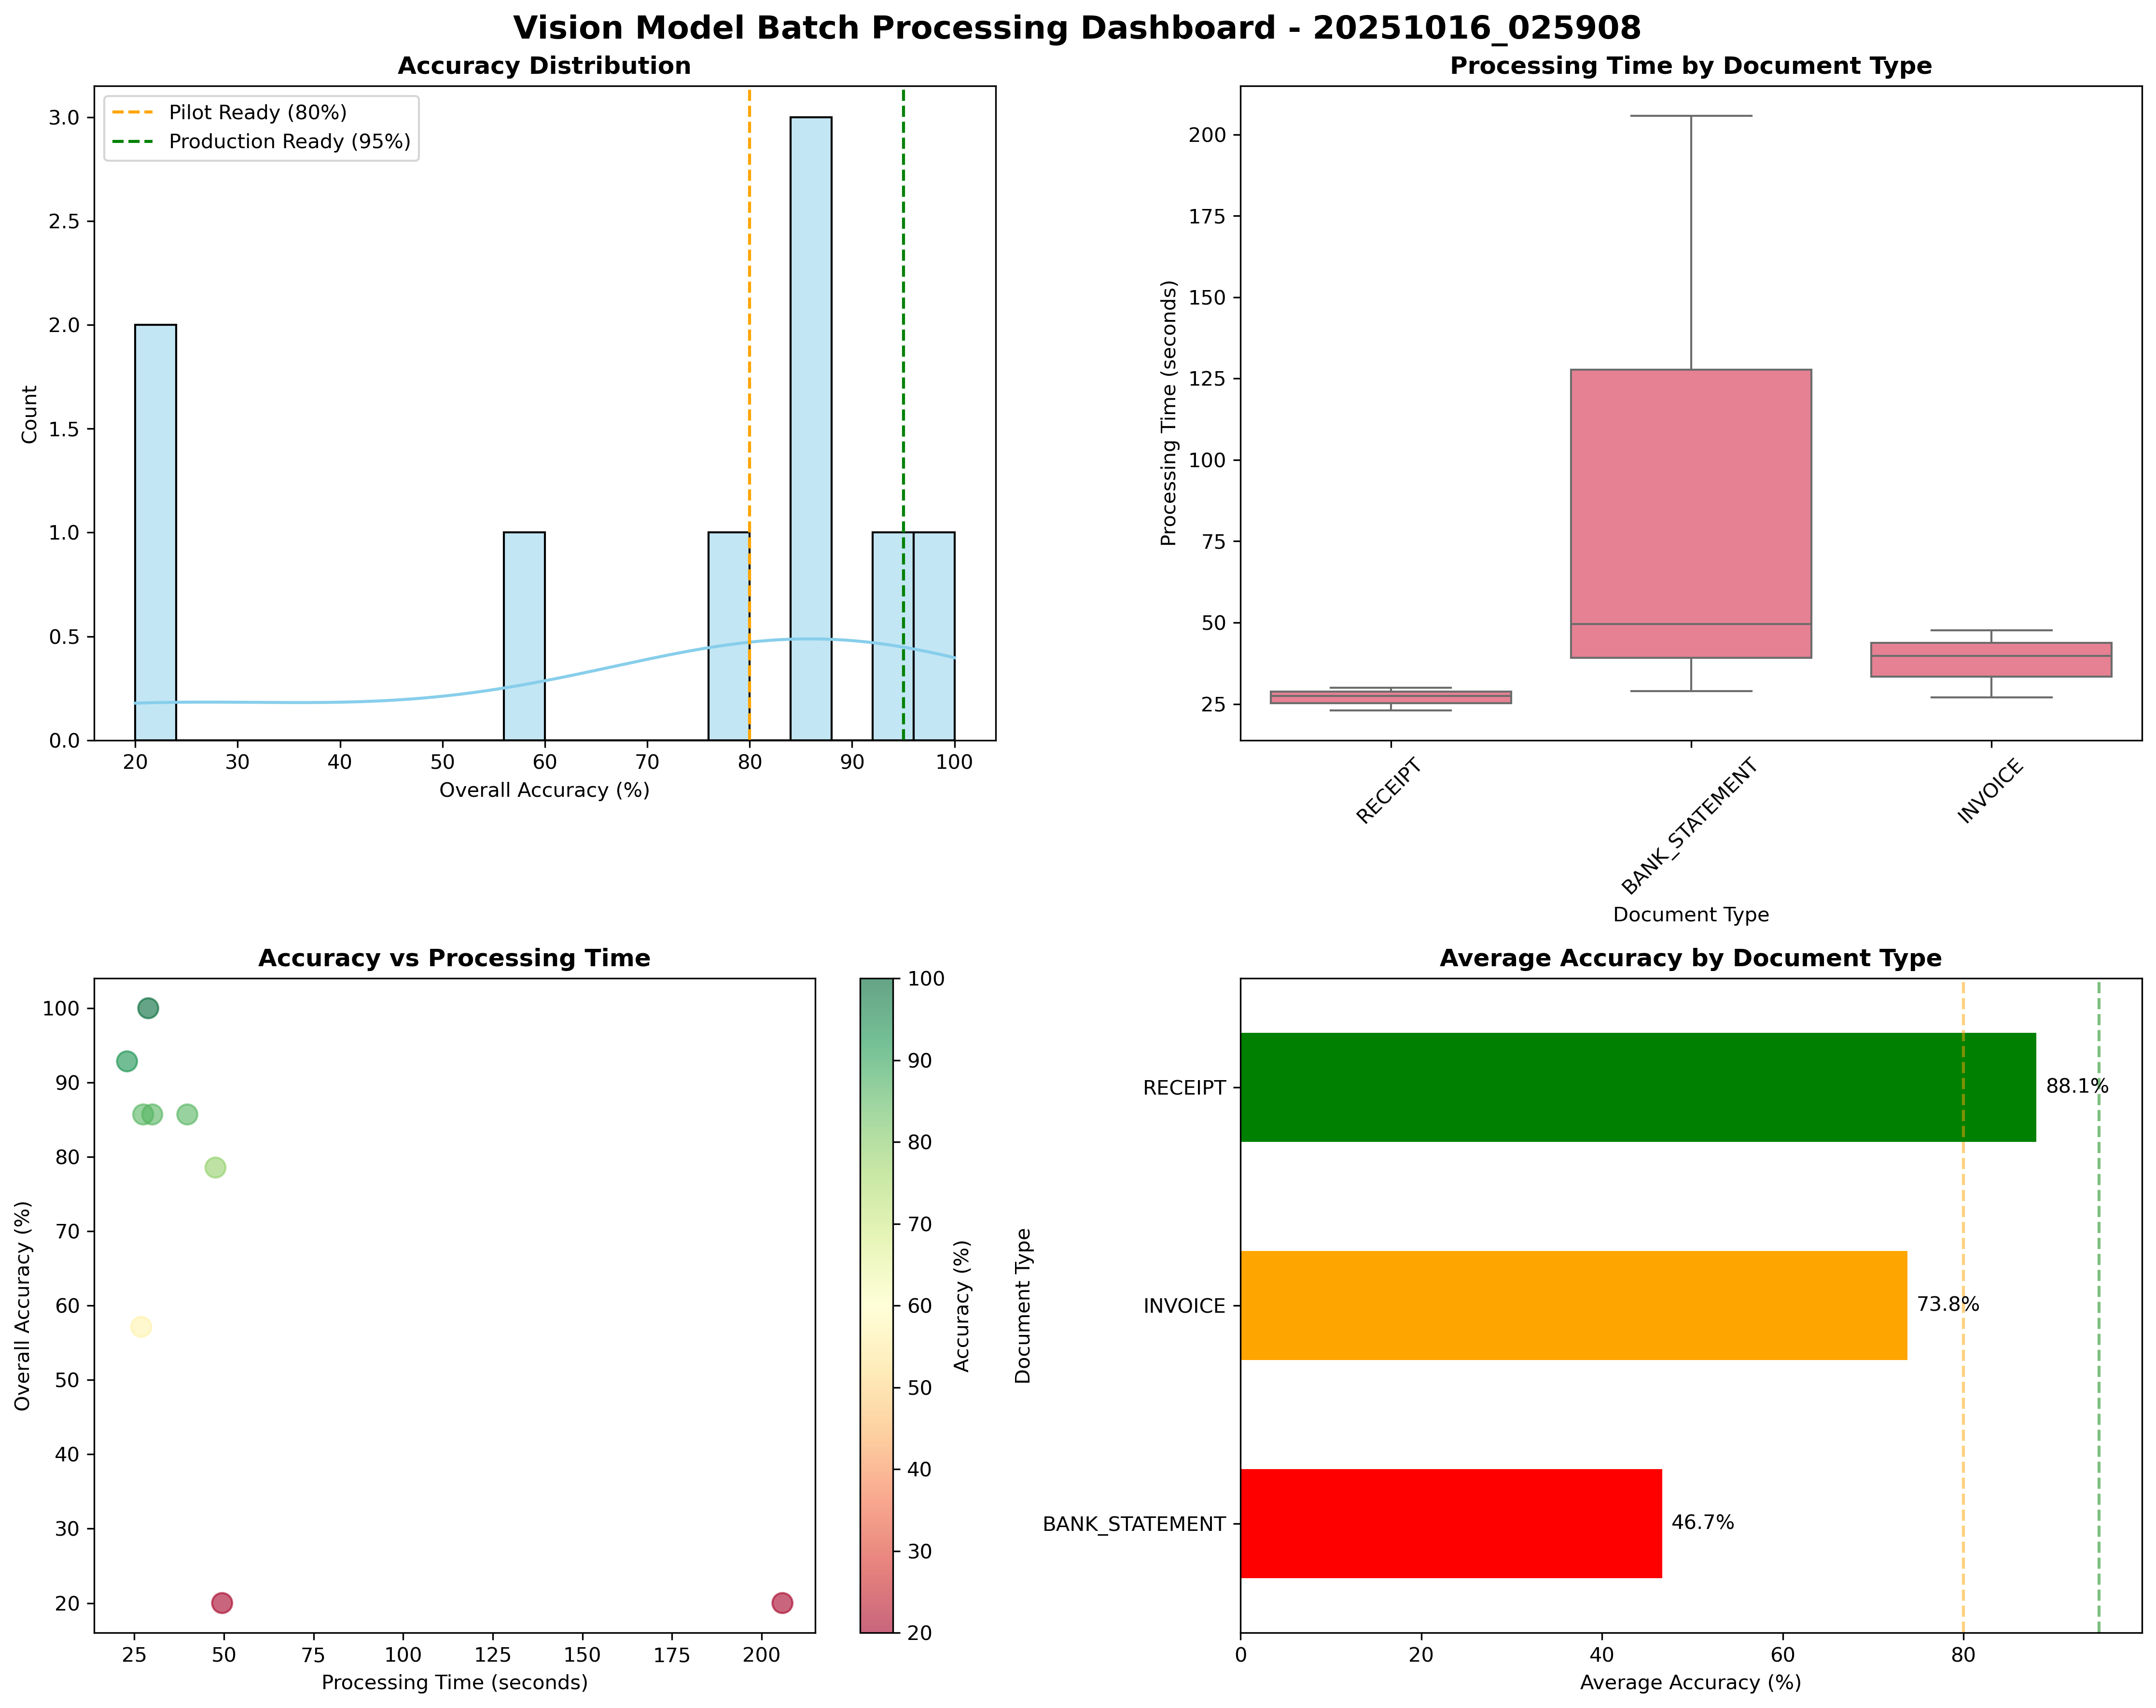

In [12]:
# Display final summary
console.rule("[bold green]InternVL3 Batch Processing Complete[/bold green]")

total_images = len(batch_results)
successful = len([r for r in batch_results if 'error' not in r])
avg_accuracy = df_results['overall_accuracy'].mean() if len(df_results) > 0 else 0

rprint(f"[bold green]‚úÖ Processed: {total_images} images[/bold green]")
rprint(f"[cyan]Success Rate: {(successful/total_images*100):.1f}%[/cyan]")
rprint(f"[cyan]Average Accuracy: {avg_accuracy:.2f}%[/cyan]")
rprint(f"[cyan]Output: {OUTPUT_BASE}[/cyan]")

# Document type distribution
if document_types_found:
    rprint("\n[bold blue]üìã Document Type Distribution:[/bold blue]")
    for doc_type, count in document_types_found.items():
        percentage = (count / total_images * 100) if total_images > 0 else 0
        rprint(f"[cyan]  {doc_type}: {count} documents ({percentage:.1f}%)[/cyan]")

# Display dashboard if available
dashboard_files = list(OUTPUT_DIRS['visualizations'].glob(f"dashboard_{BATCH_TIMESTAMP}.png"))
if dashboard_files:
    from IPython.display import Image, display
    dashboard_path = dashboard_files[0]
    rprint("\n[bold blue]üìä Visual Dashboard:[/bold blue]")
    display(Image(str(dashboard_path)))
else:
    rprint(f"\n[yellow]‚ö†Ô∏è Dashboard not found in {OUTPUT_DIRS['visualizations']}[/yellow]")

In [13]:
# Calculate zero accuracy extractions
zero_accuracy_count = 0
zero_accuracy_images = []
total_evaluated = 0

for result in batch_results:
    # Check if evaluation data exists (not inference-only mode)
    evaluation = result.get("evaluation", {})

    if evaluation and not evaluation.get("inference_only", False):
        total_evaluated += 1
        accuracy = evaluation.get("overall_accuracy", 0)

        if accuracy == 0.0:
            zero_accuracy_count += 1
            zero_accuracy_images.append(
                {
                    "image_name": result.get("image_name", "unknown"),
                    "document_type": result.get("document_type", "unknown"),
                    "fields_extracted": evaluation.get("fields_extracted", 0),
                    "total_fields": evaluation.get("total_fields", 0),
                }
            )

# Display results
if total_evaluated > 0:
    console.rule("[bold red]Zero Accuracy Analysis[/bold red]")

    rprint(f"[cyan]Total documents evaluated: {total_evaluated}[/cyan]")
    rprint(f"[red]Documents with 0% accuracy: {zero_accuracy_count}[/red]")

    if zero_accuracy_count > 0:
        percentage = (zero_accuracy_count / total_evaluated) * 100
        rprint(f"[red]Zero accuracy rate: {percentage:.1f}%[/red]")

        rprint("\n[bold red]Documents with 0% Accuracy:[/bold red]")
        for i, img_info in enumerate(zero_accuracy_images, 1):
            rprint(f"  {i}. {img_info['image_name']} ({img_info['document_type']})")
            rprint(
                f"     Fields extracted: {img_info['fields_extracted']}/{img_info['total_fields']}"
            )
    else:
        rprint(
            "[green]‚úÖ No documents with 0% accuracy - all extractions had some success![/green]"
        )
else:
    rprint(
        "[yellow]‚ö†Ô∏è Running in inference-only mode - no accuracy metrics available[/yellow]"
    )


‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Zero Accuracy Analysis ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

Total documents evaluated: 9

Documents with 0% accuracy: 0

‚úÖ No documents with 0% accuracy - all extractions had some success!